In [1]:
library(tidyverse)
library(ggplot2)
library(gridExtra)

options(repr.matrix.max.cols = 50, repr.matrix.max.rows = 10)


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attachement du package : ‘gridExtra’


L'objet suivant est masqué depuis ‘package:dplyr’:

    combine




# Data generation 

The data have been generated using *data_generation_b.R*.  

The last update is:

In [2]:
fs::file_info('01_test.csv')['modification_time']

modification_time
<dttm>
2024-11-21 09:45:50


We generate 100 training datasets and 1 test dataset, considering:
- $i \in [1,500]$ individuals 
- repeated measures on $t \in [0,25]$ time periods

For each individual and time period we generate:
- $k \in [1,7]$ time dependant variables: $X^*_{k,i}(t)$
- 1 categorical variable: $X^*_{8,i}(t)$
- 1 variable of interest for a "fixed effect" study: $Y^*_{fixed,i}(t)$
- 1 variable of interest for a "mixed effect" study: $Y^*_{mixed,i}(t)$  
- the corresponding "noisy" variables of interest: $Y_{fixed,i}(t)$,  $Y_{mixed,i}(t)$  


The training will be done using the noisy targets.   
The evaluation will be done using both "no noise" and noisy targets, to see if the model can correct the noise in its prediction.

In [3]:
data <- read.csv2("01_test.csv")
data


individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,x2_x5,x4_x7,x6_x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,7.642962,6.541205,-4.901404,-4.930665,-2.762202,-2.708554,-0.5241245,-0.68405305,3.799585,3.517766,29.44603,30.38263,4.8340702,3.94119605,0,-18.62330,-2.53365458,0,-14.14709,-16.40112,-10.270811,-10.709328
1,1,9.115644,9.473100,-4.442349,-4.361045,-2.761245,-2.881917,-0.4128151,-0.44128759,3.900059,3.688365,30.60259,29.79593,2.6281198,2.63455643,0,-17.32542,-1.08492761,0,-13.23379,-13.50480,-9.577035,-9.098007
1,2,10.588327,9.902374,-4.173819,-4.263328,-2.758375,-2.779620,-0.3120983,-0.28328090,4.000393,3.416989,31.78143,32.55894,1.1825620,0.86421513,0,-16.69692,-0.36907552,0,-12.79182,-12.98460,-9.241133,-9.166685
1,3,12.061010,12.529263,-3.983294,-3.820831,-2.753591,-2.649039,-0.2209659,-0.20921329,4.100446,4.702716,32.98255,32.79740,0.4781129,0.07465715,0,-16.33328,-0.10564663,0,-12.53293,-12.42829,-9.046099,-7.888457
1,4,13.533692,13.084102,-3.835512,-3.638428,-2.746894,-2.827505,-0.1385059,-0.01199248,4.200081,3.805776,34.20595,33.88844,0.1841934,-0.45020871,0,-16.10946,-0.02551186,0,-12.37185,-13.11701,-8.925675,-9.075263
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
500,21,53.02048,52.32147,-2.272128,-2.236097,-1.706892,-1.640332,1.684388,1.799199,8.846906,9.003809,33.76678,35.93840,0.2283129,0.2579981,1,-20.10131,0.3845675,33.76678,14.25581,13.53326,3.614660,3.089745
500,22,55.20854,55.21803,-2.240013,-2.426036,-1.688810,-1.665168,1.700566,1.514891,8.851217,8.432949,34.25289,35.13829,0.1936494,-0.1151003,1,-19.82684,0.3293136,34.25289,14.36578,14.03586,3.974612,1.382215
500,23,57.39660,56.73622,-2.209264,-2.319933,-1.669887,-1.666301,1.715204,1.755337,8.854417,8.721429,34.74247,33.50737,0.1641400,0.7886229,1,-19.56174,0.2815335,34.74247,14.48037,15.10689,4.330982,4.661281


In [4]:
data$individus <- as.factor(data$individus)


In [5]:
columns <- colnames(data)
values_columns_noise <- columns[grepl(".*obs", columns)]
values_columns_nonoise <- gsub("_obs", "", values_columns_noise)

In [6]:
values_columns_noise

[1] "x1_obs"      "x2_obs"      "x3_obs"      "x4_obs"      "x5_obs"     
[6] "x6_obs"      "x7_obs"      "y_mixed_obs" "y_fixed_obs"

In [7]:
values_columns_nonoise

[1] "x1"      "x2"      "x3"      "x4"      "x5"      "x6"      "x7"     
[8] "y_mixed" "y_fixed"

## Box plots

In [8]:
Nsteps <- 10

times <- unique(data$temps)
times_violin <- round(seq(0, length(times) - 1, length.out = Nsteps))
times_violin


[1]  0  3  6  8 11 14 17 19 22 25

In [9]:
data_box <- filter(data, data$temps %in% times_violin)
data_box


individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,x2_x5,x4_x7,x6_x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,7.642962,6.541205,-4.901404,-4.930665,-2.762202,-2.708554,-0.524124489,-0.68405305,3.799585,3.517766,29.44603,30.38263,4.8340702085,3.94119605,0,-18.62330,-2.533655e+00,0,-14.14709,-16.40112,-10.270811,-10.709328
1,3,12.061010,12.529263,-3.983294,-3.820831,-2.753591,-2.649039,-0.220965859,-0.20921329,4.100446,4.702716,32.98255,32.79740,0.4781129267,0.07465715,0,-16.33328,-1.056466e-01,0,-12.53293,-12.42829,-9.046099,-7.888457
1,6,16.479057,16.441685,-3.612674,-3.459398,-2.727759,-2.673003,0.003619577,-0.13194512,4.397558,4.195565,36.71957,36.98158,0.0260973505,-0.28825114,0,-15.88694,9.446138e-05,0,-12.21056,-11.32191,-8.805703,-9.169623
1,8,19.424423,18.975003,-3.446235,-3.516558,-2.700970,-2.801698,0.119982042,-0.07816042,4.591776,4.404906,39.32231,38.71132,0.0036454317,0.12888122,0,-15.82434,4.373863e-04,0,-12.16504,-12.73799,-8.771918,-9.850792
1,11,23.842470,24.097851,-3.255710,-3.207449,-2.646435,-2.575297,0.256199995,0.33592981,4.874884,4.901872,43.39351,44.01687,0.0001897221,-0.23586839,0,-15.87121,4.860680e-05,0,-12.19912,-11.99024,-8.797212,-8.446738
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
500,14,37.70406,38.01274,-2.548834,-2.615982,-1.809917,-1.835188,1.512050,1.426587,8.730173,8.201795,30.46130,31.60723,0.7010091,1.3868143,1,-22.25177,1.0599611,30.46130,13.63159,14.34856,1.012319,3.085078
500,17,44.26824,43.25045,-2.417110,-2.459084,-1.770810,-1.886766,1.600778,1.655261,8.808655,8.924299,31.85709,31.85079,0.4371031,0.7474518,1,-21.29149,0.6997051,31.85709,13.86707,14.54483,2.139722,3.576995
500,19,48.64436,48.00761,-2.340988,-2.397418,-1.740533,-1.727371,1.646750,1.595452,8.833290,9.925190,32.80498,30.95778,0.3165833,0.3956640,1,-20.67863,0.5213335,32.80498,14.05077,14.51715,2.883851,2.602282


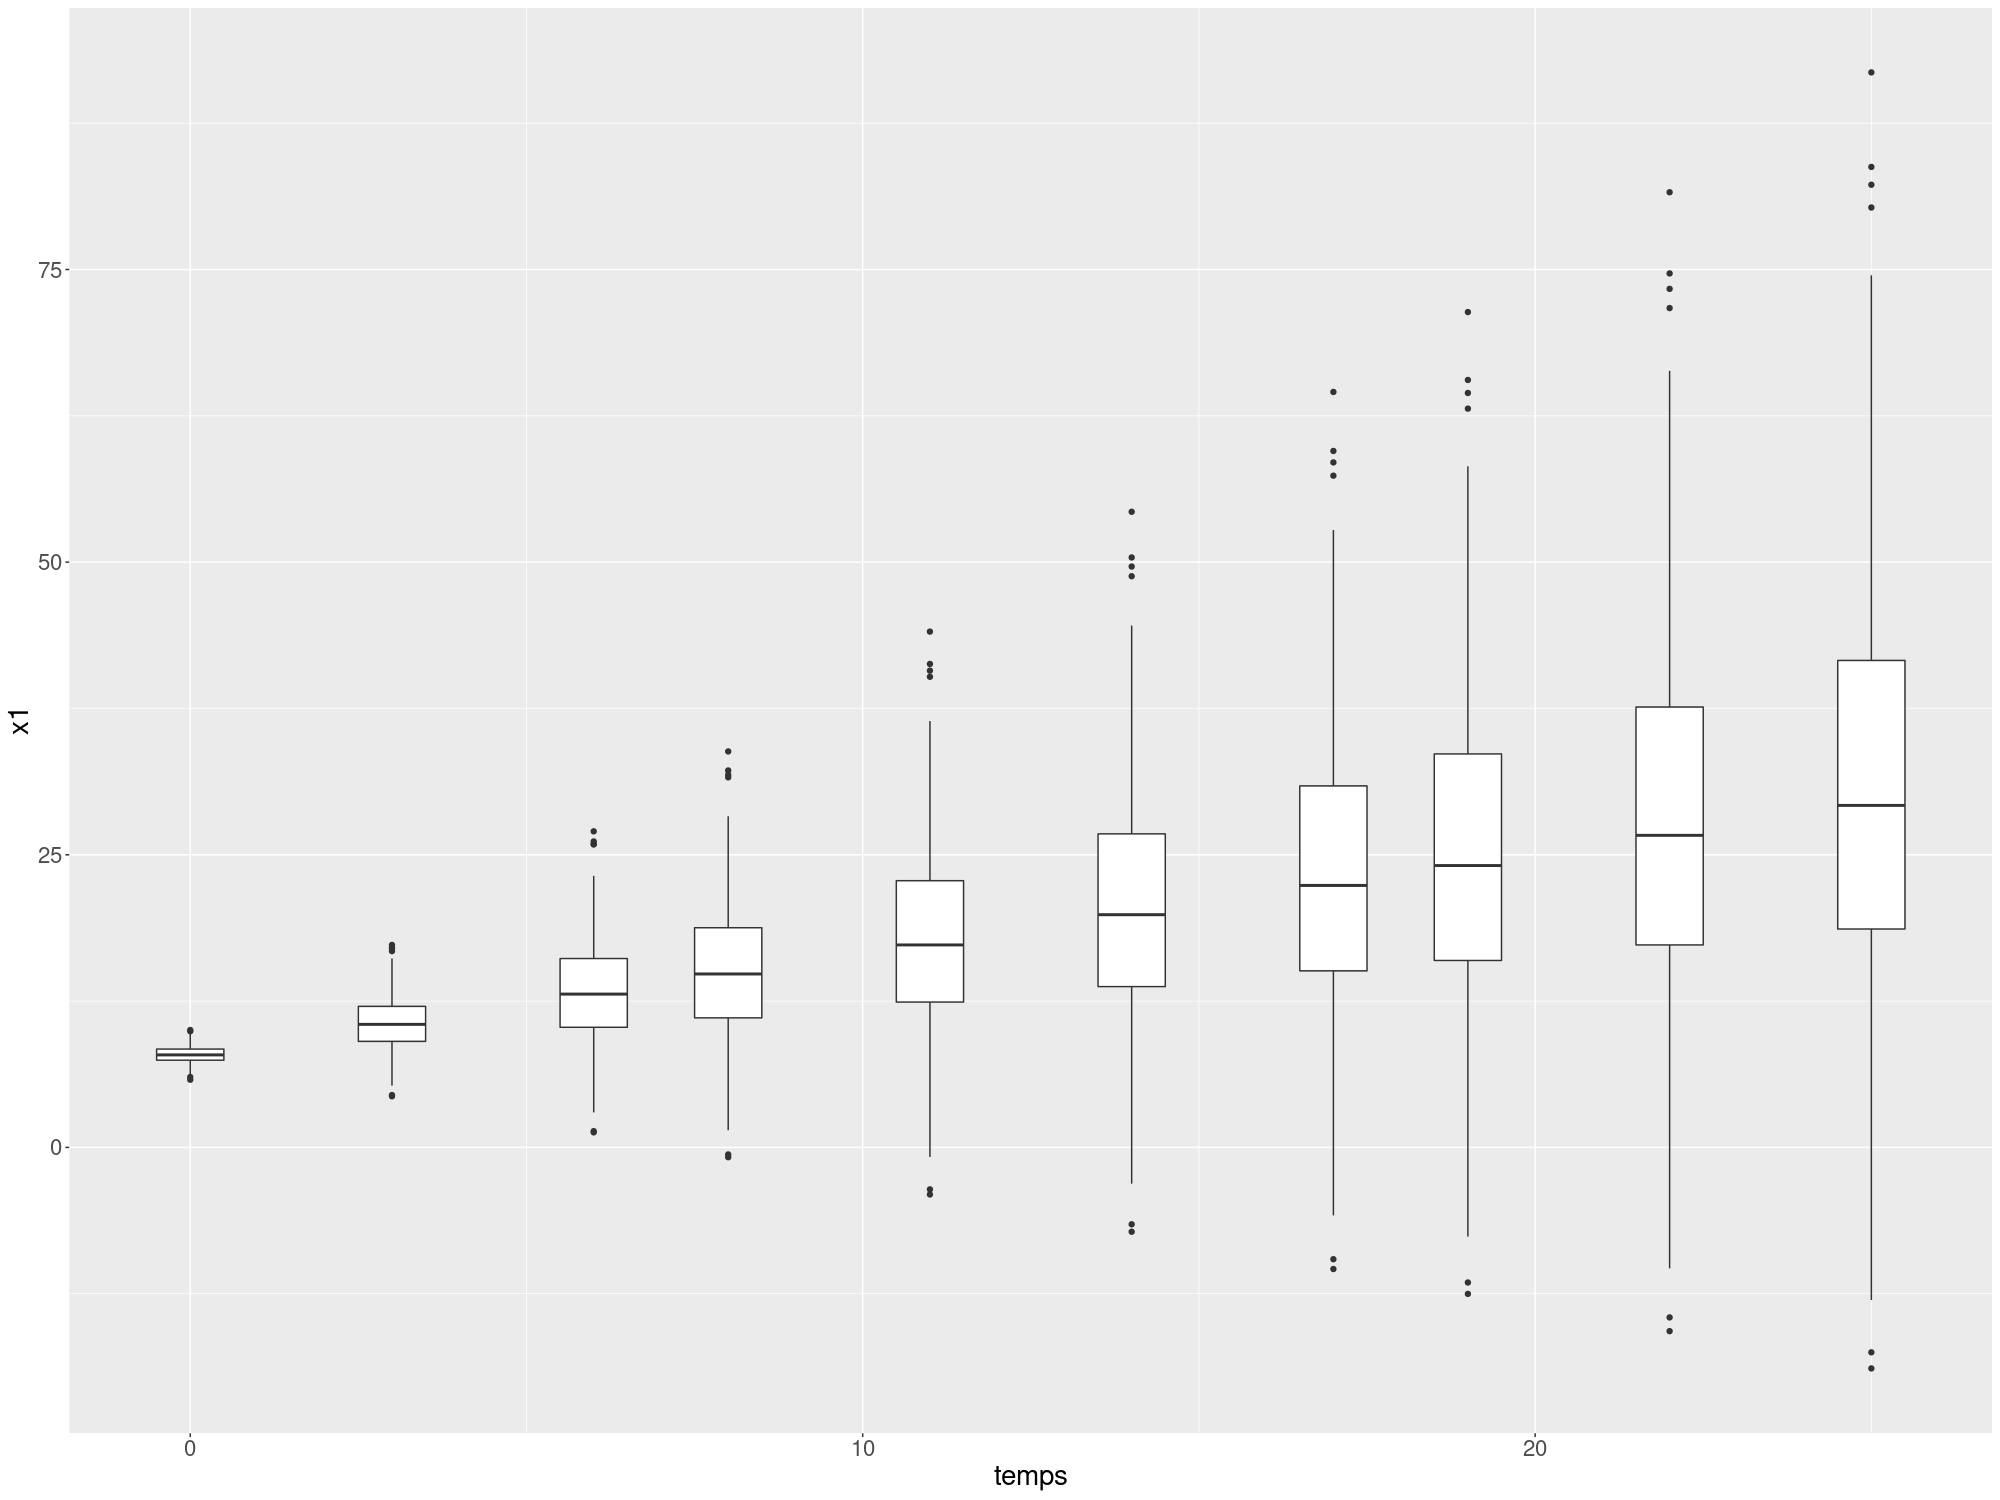

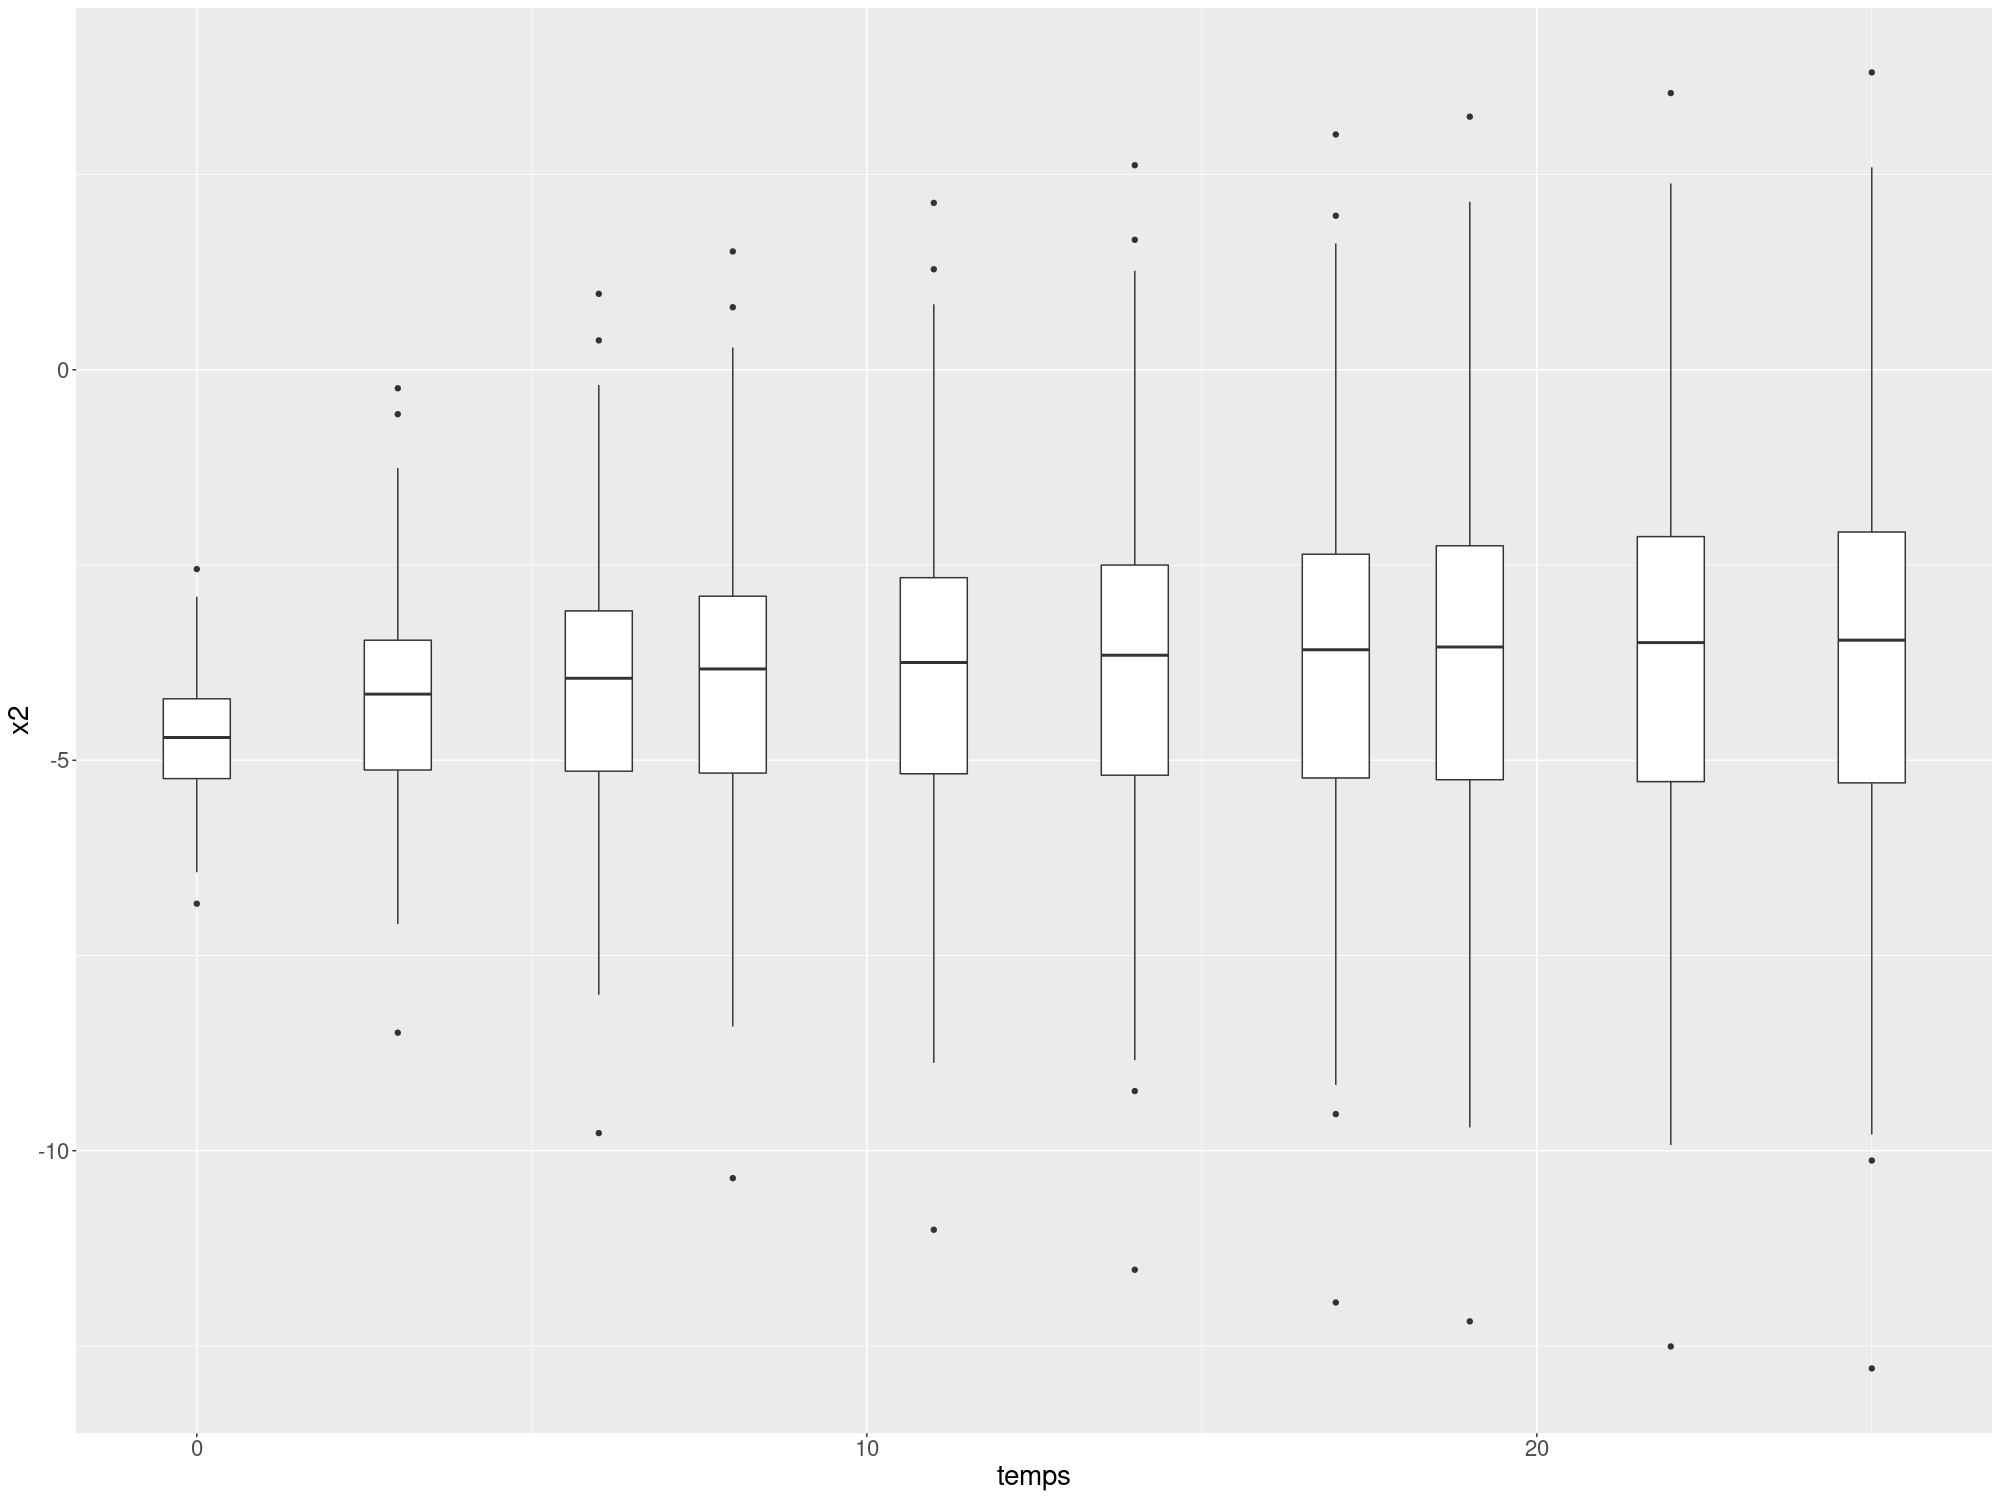

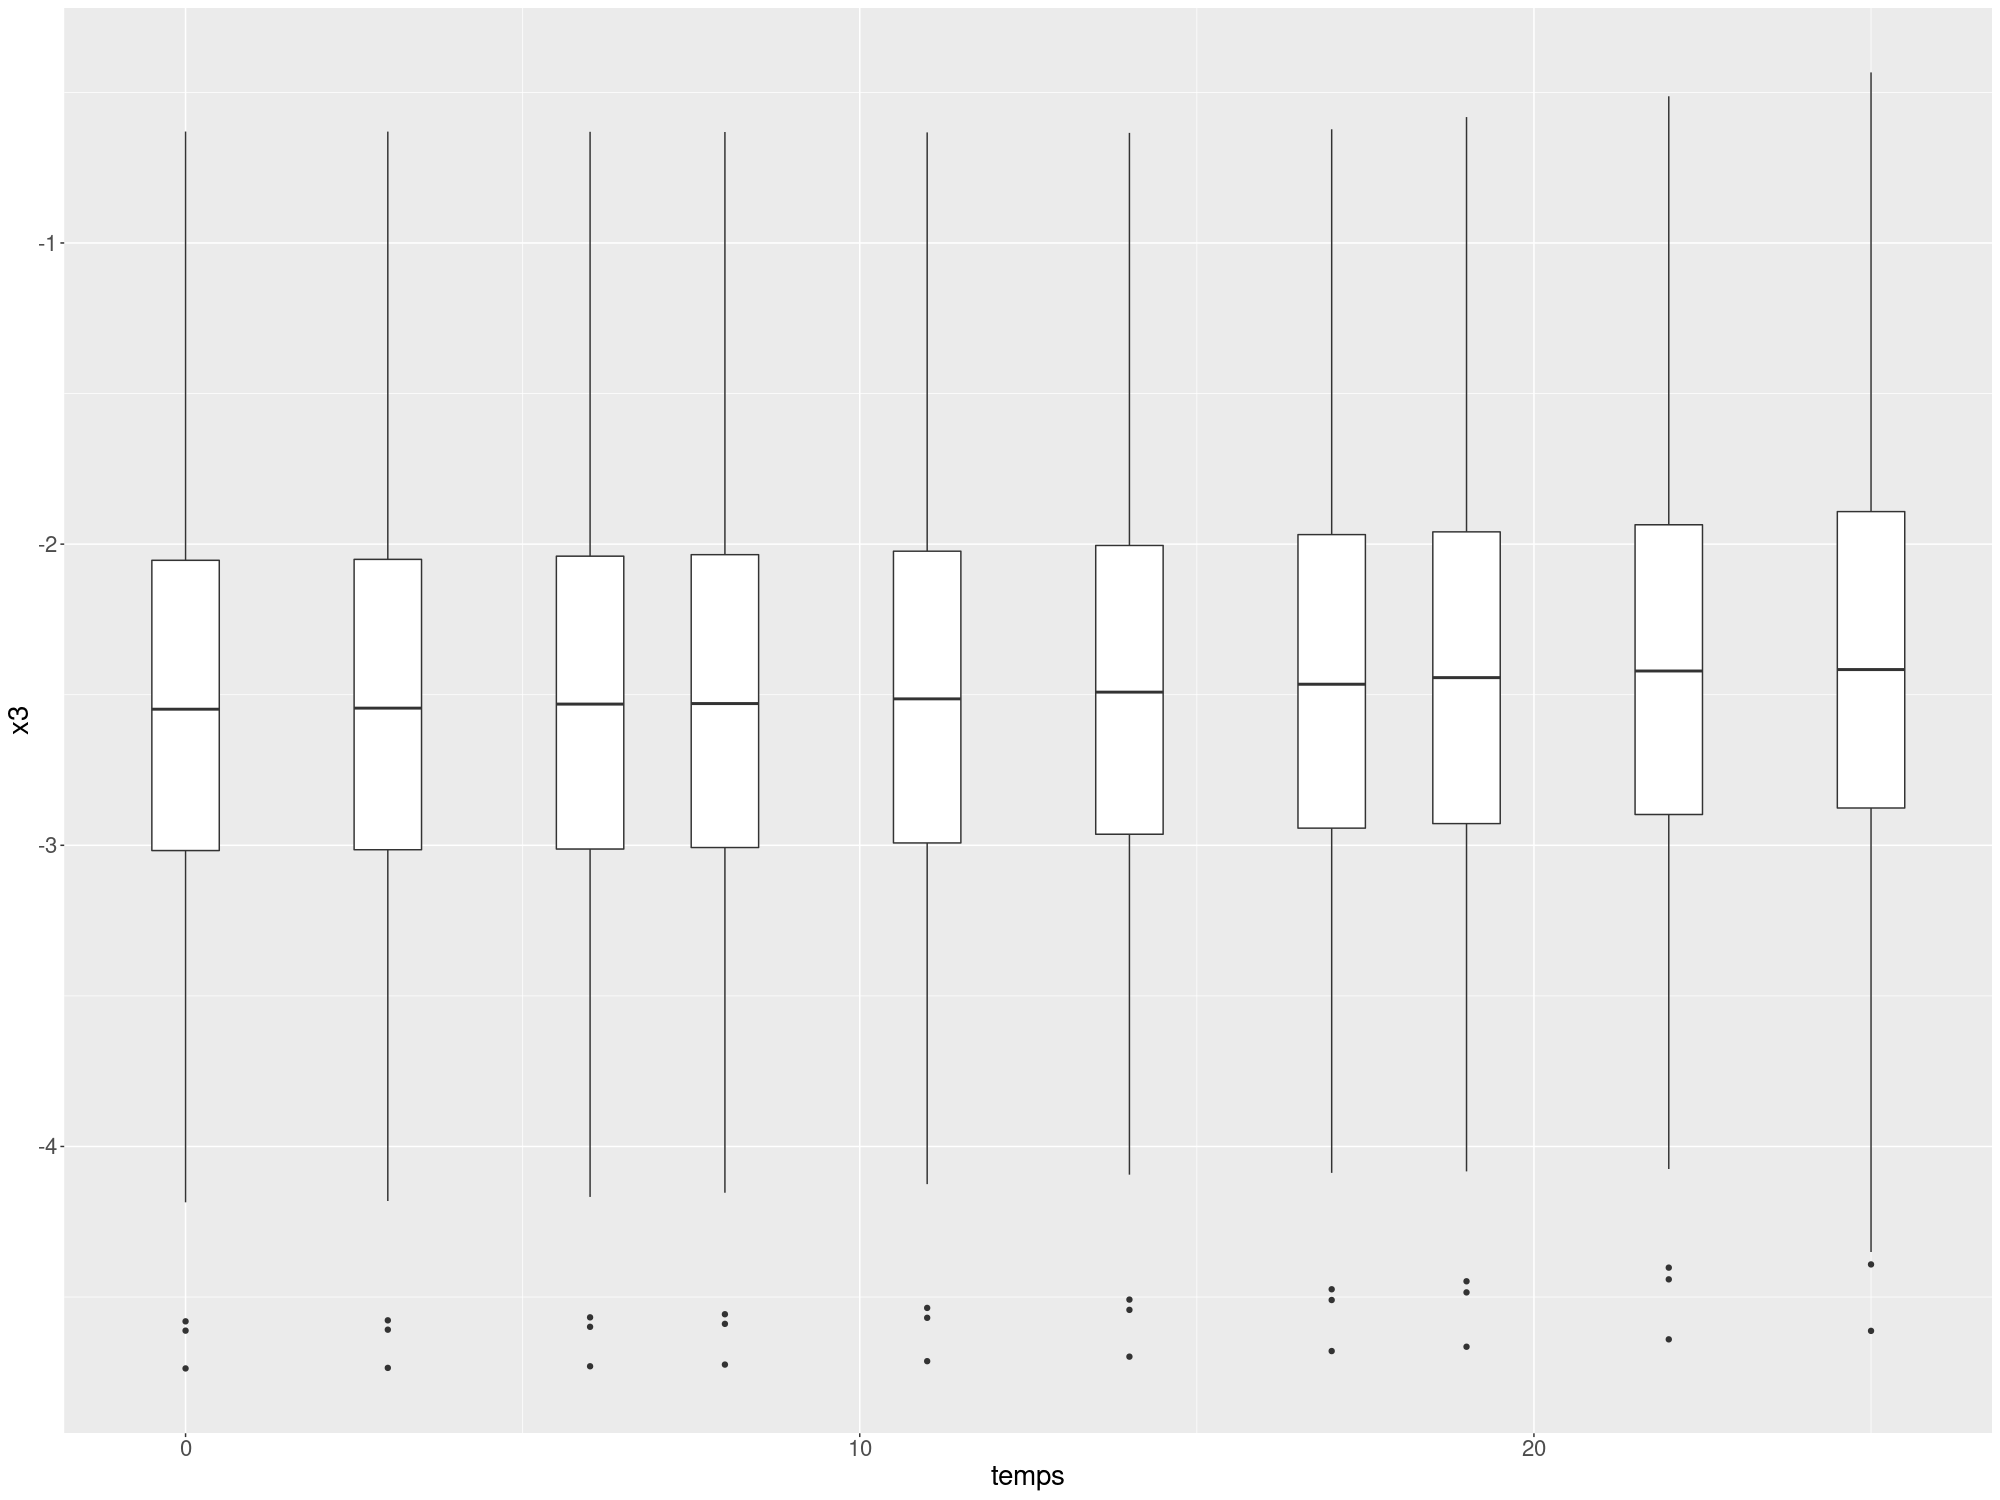

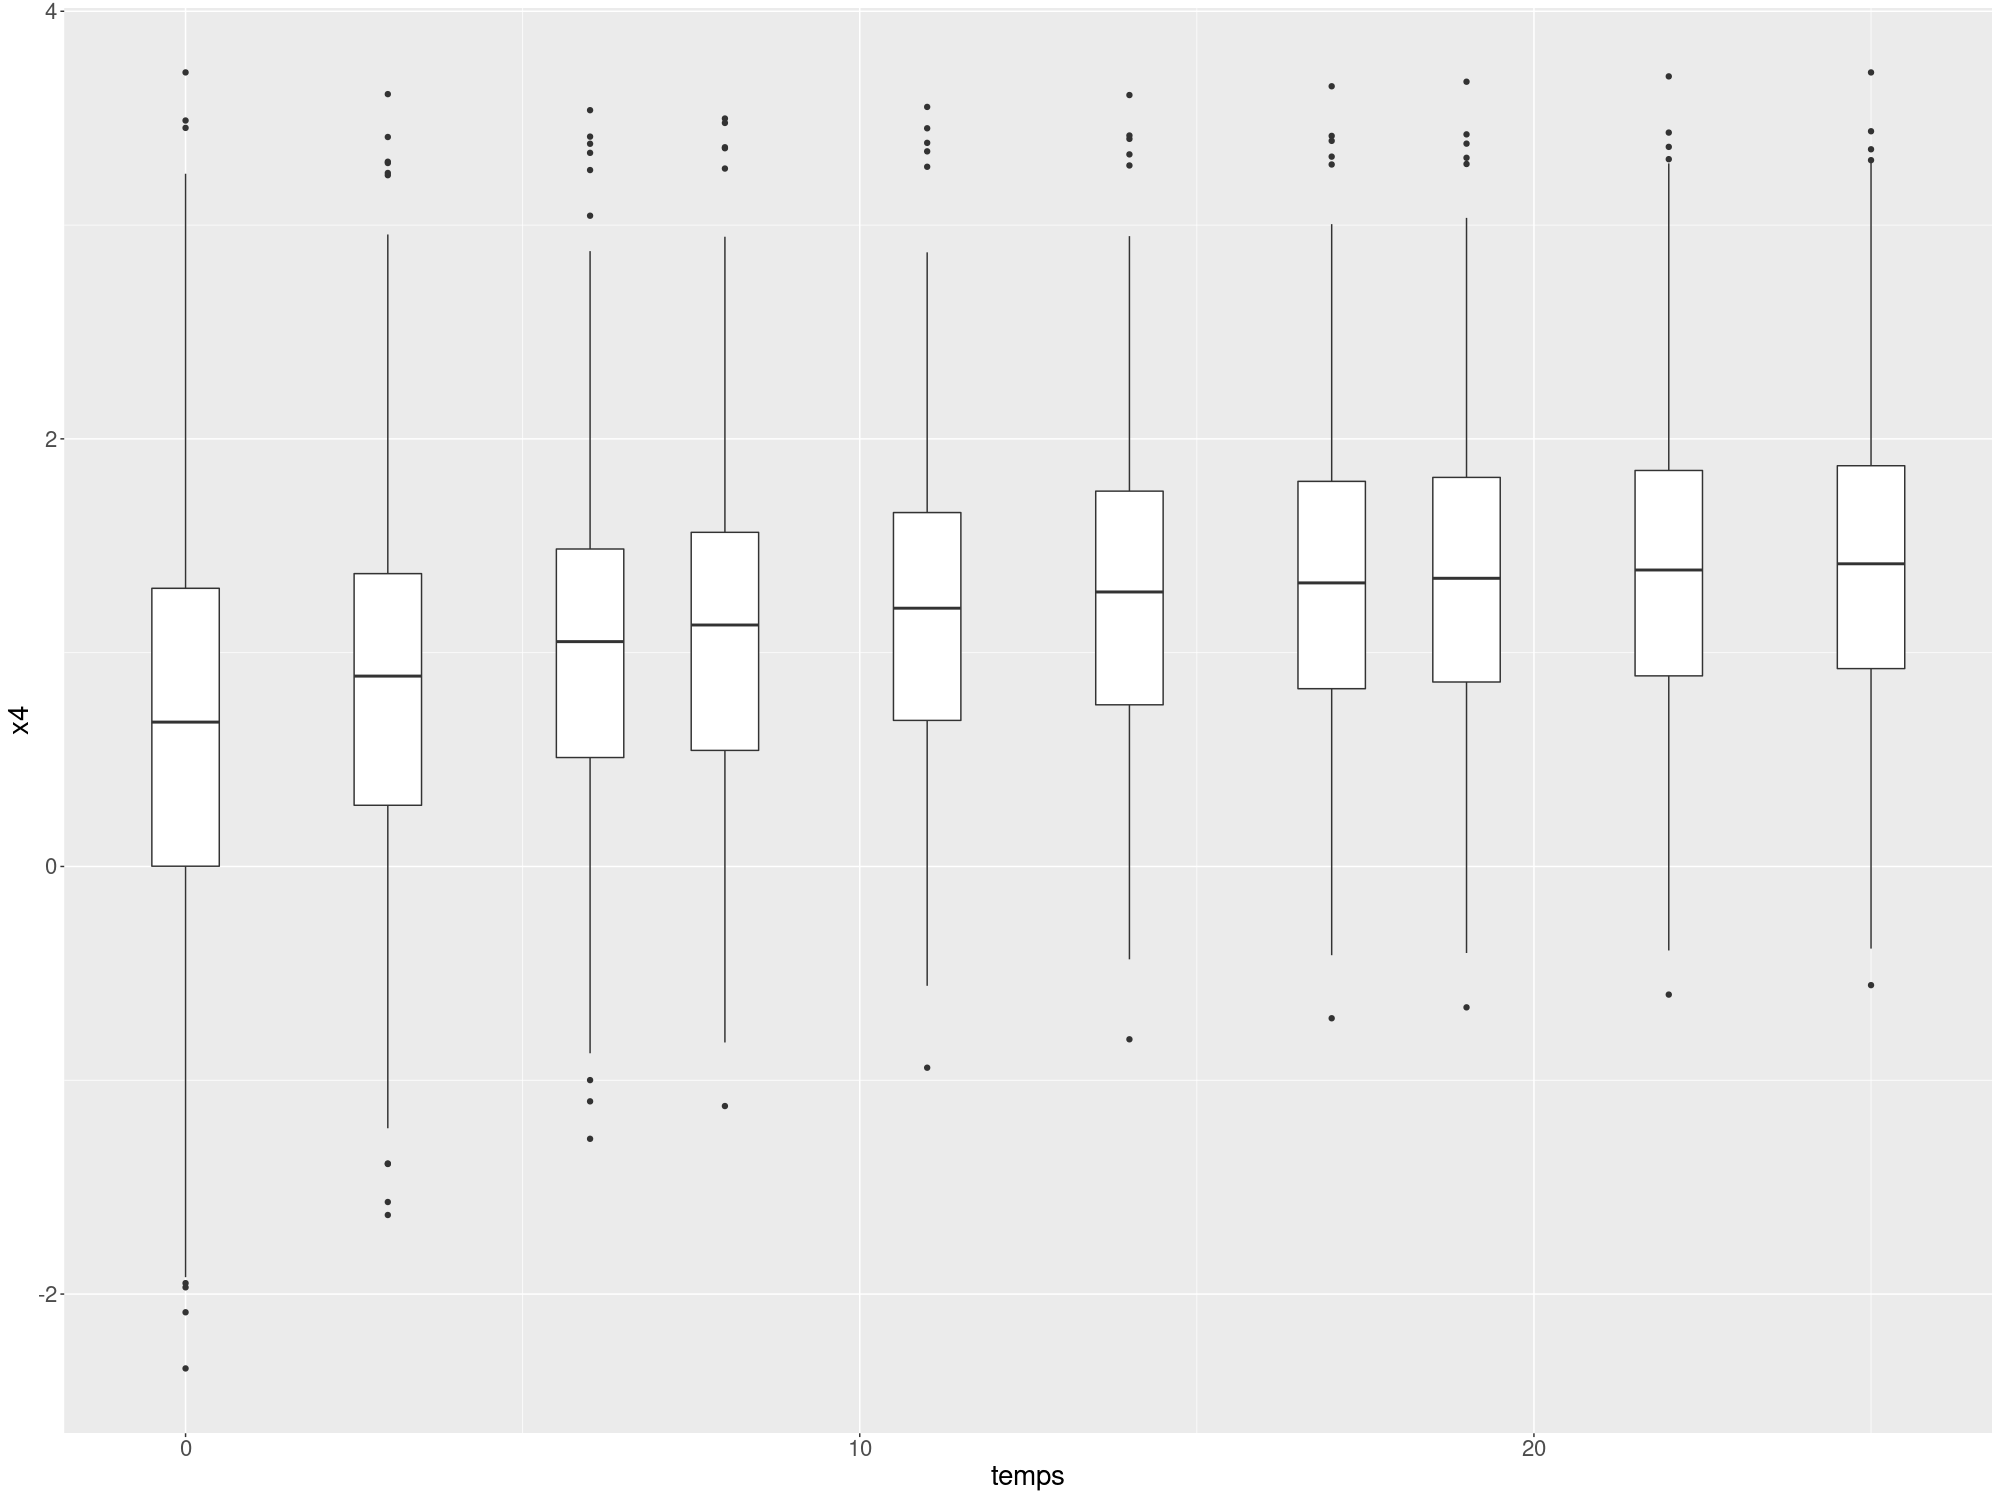

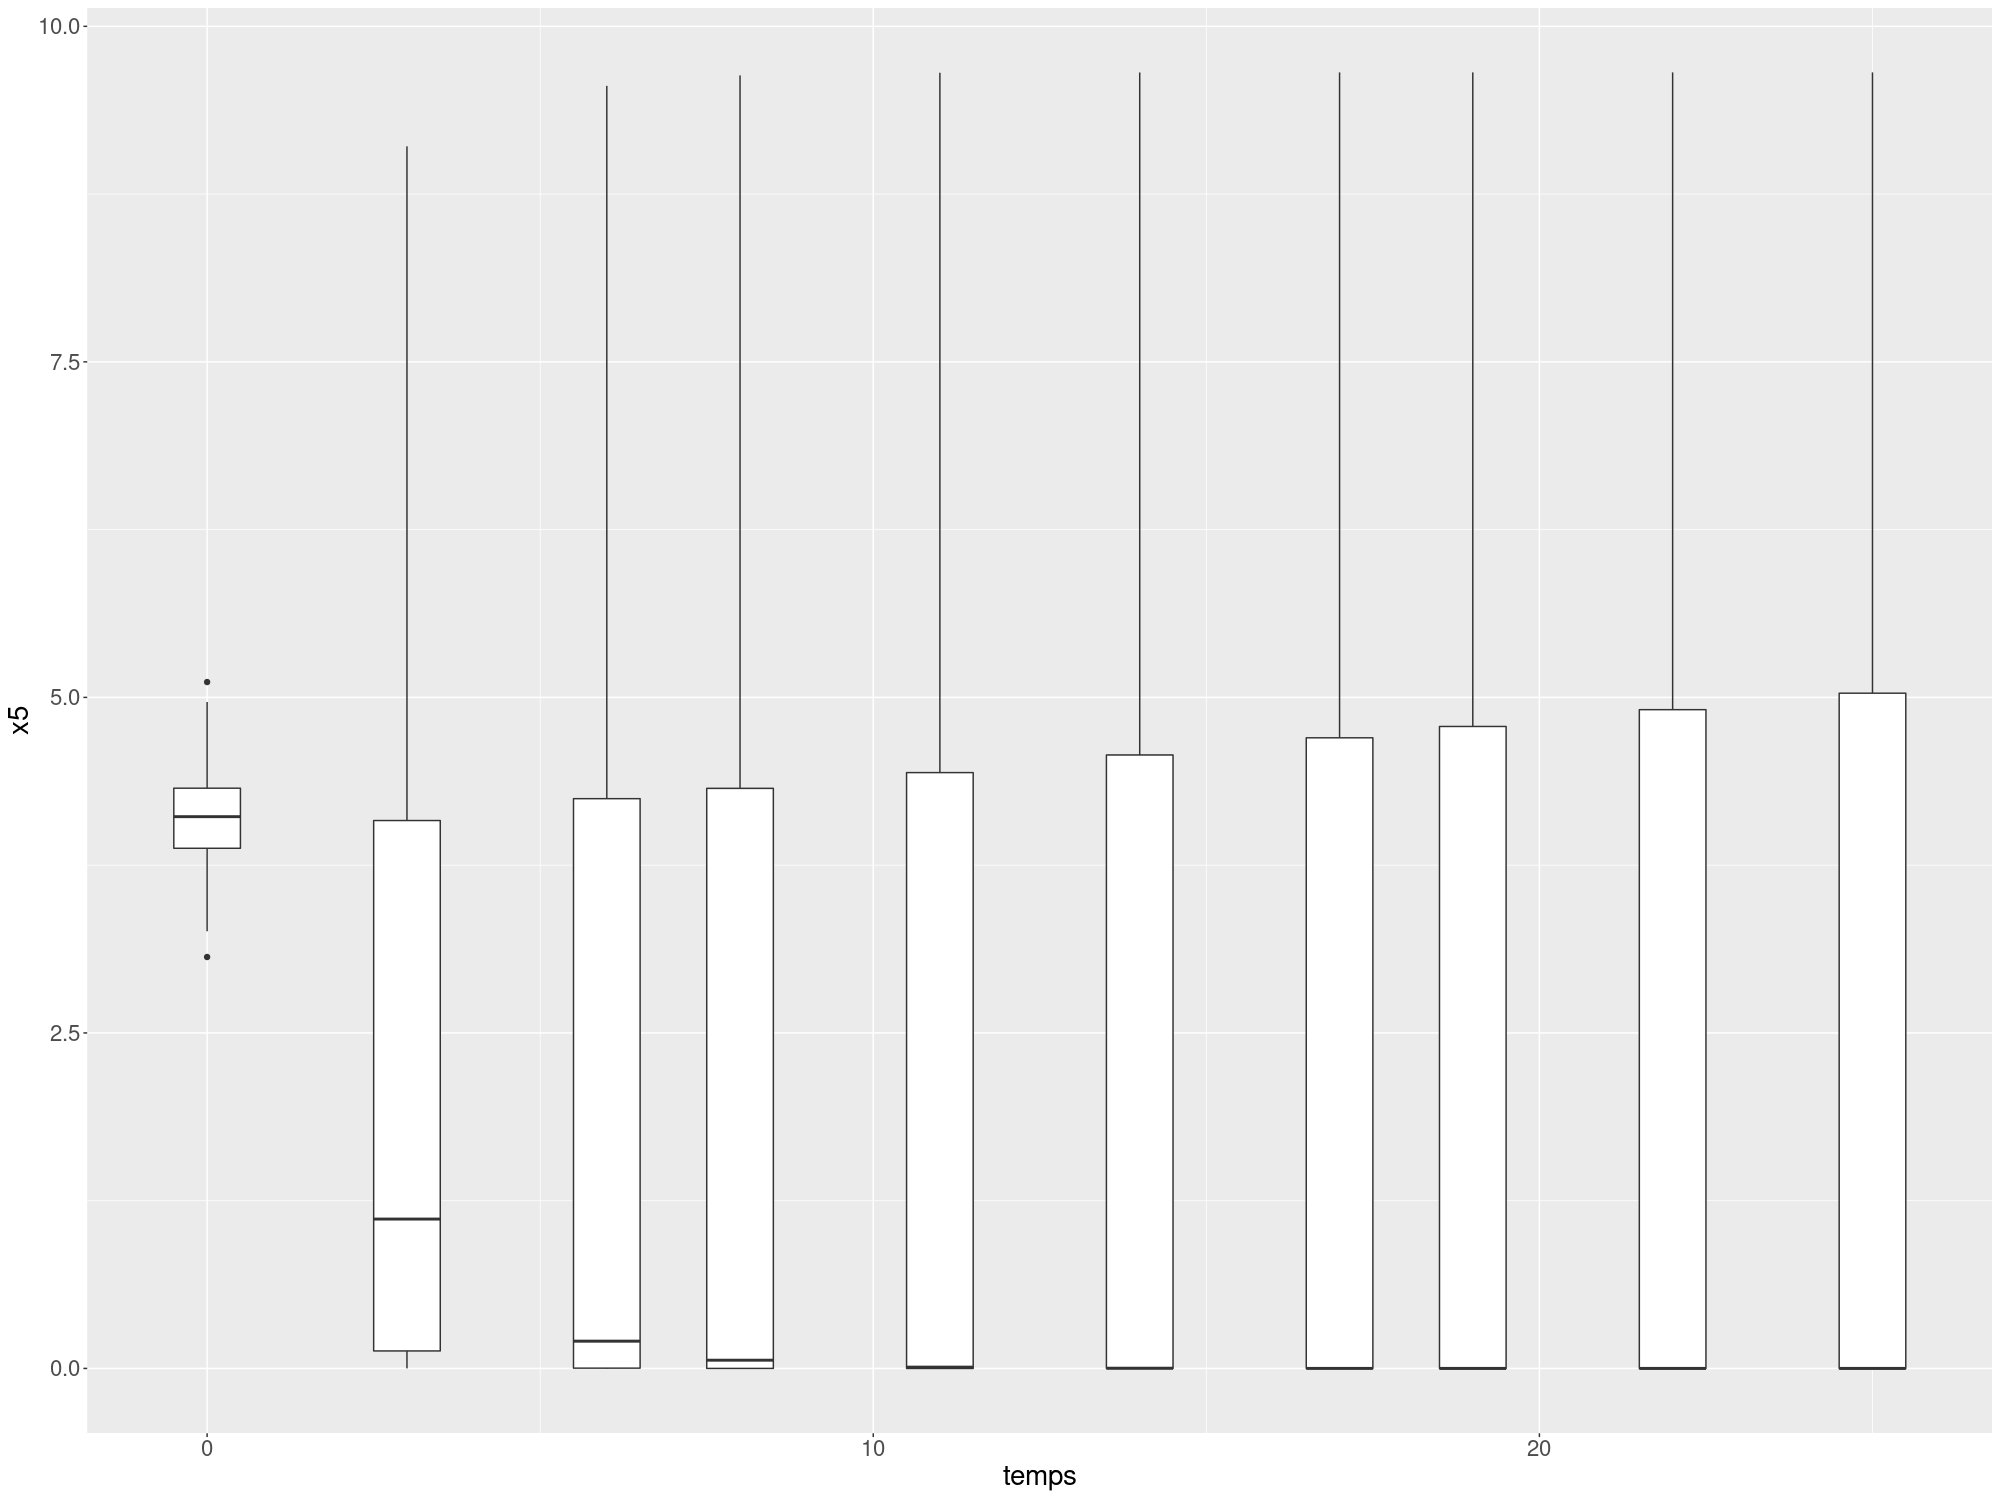

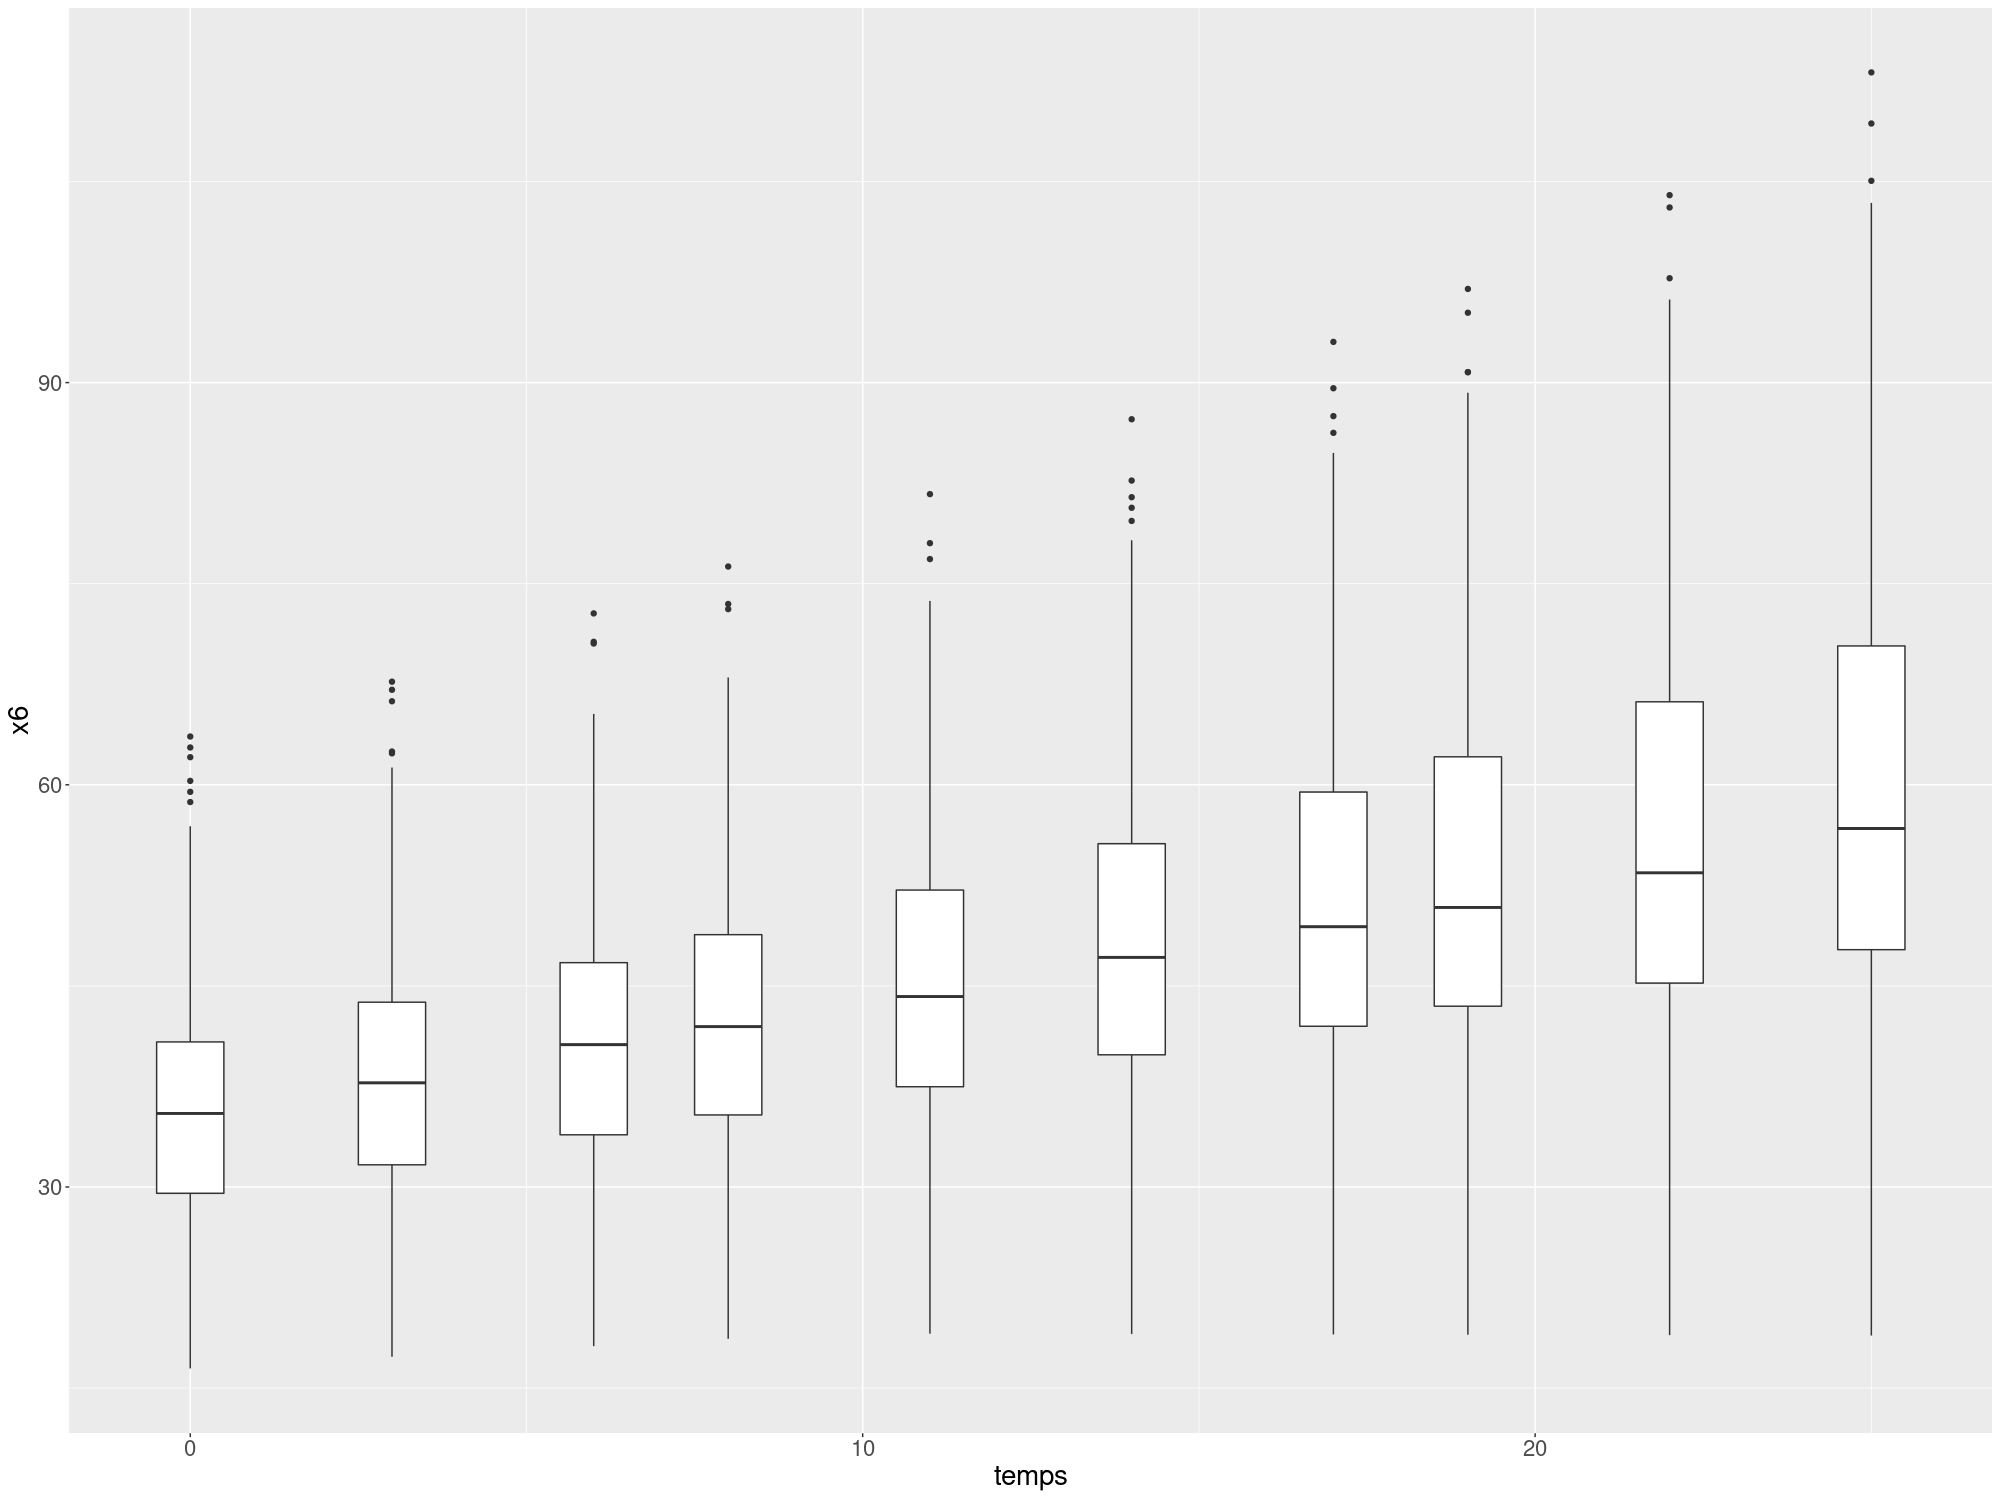

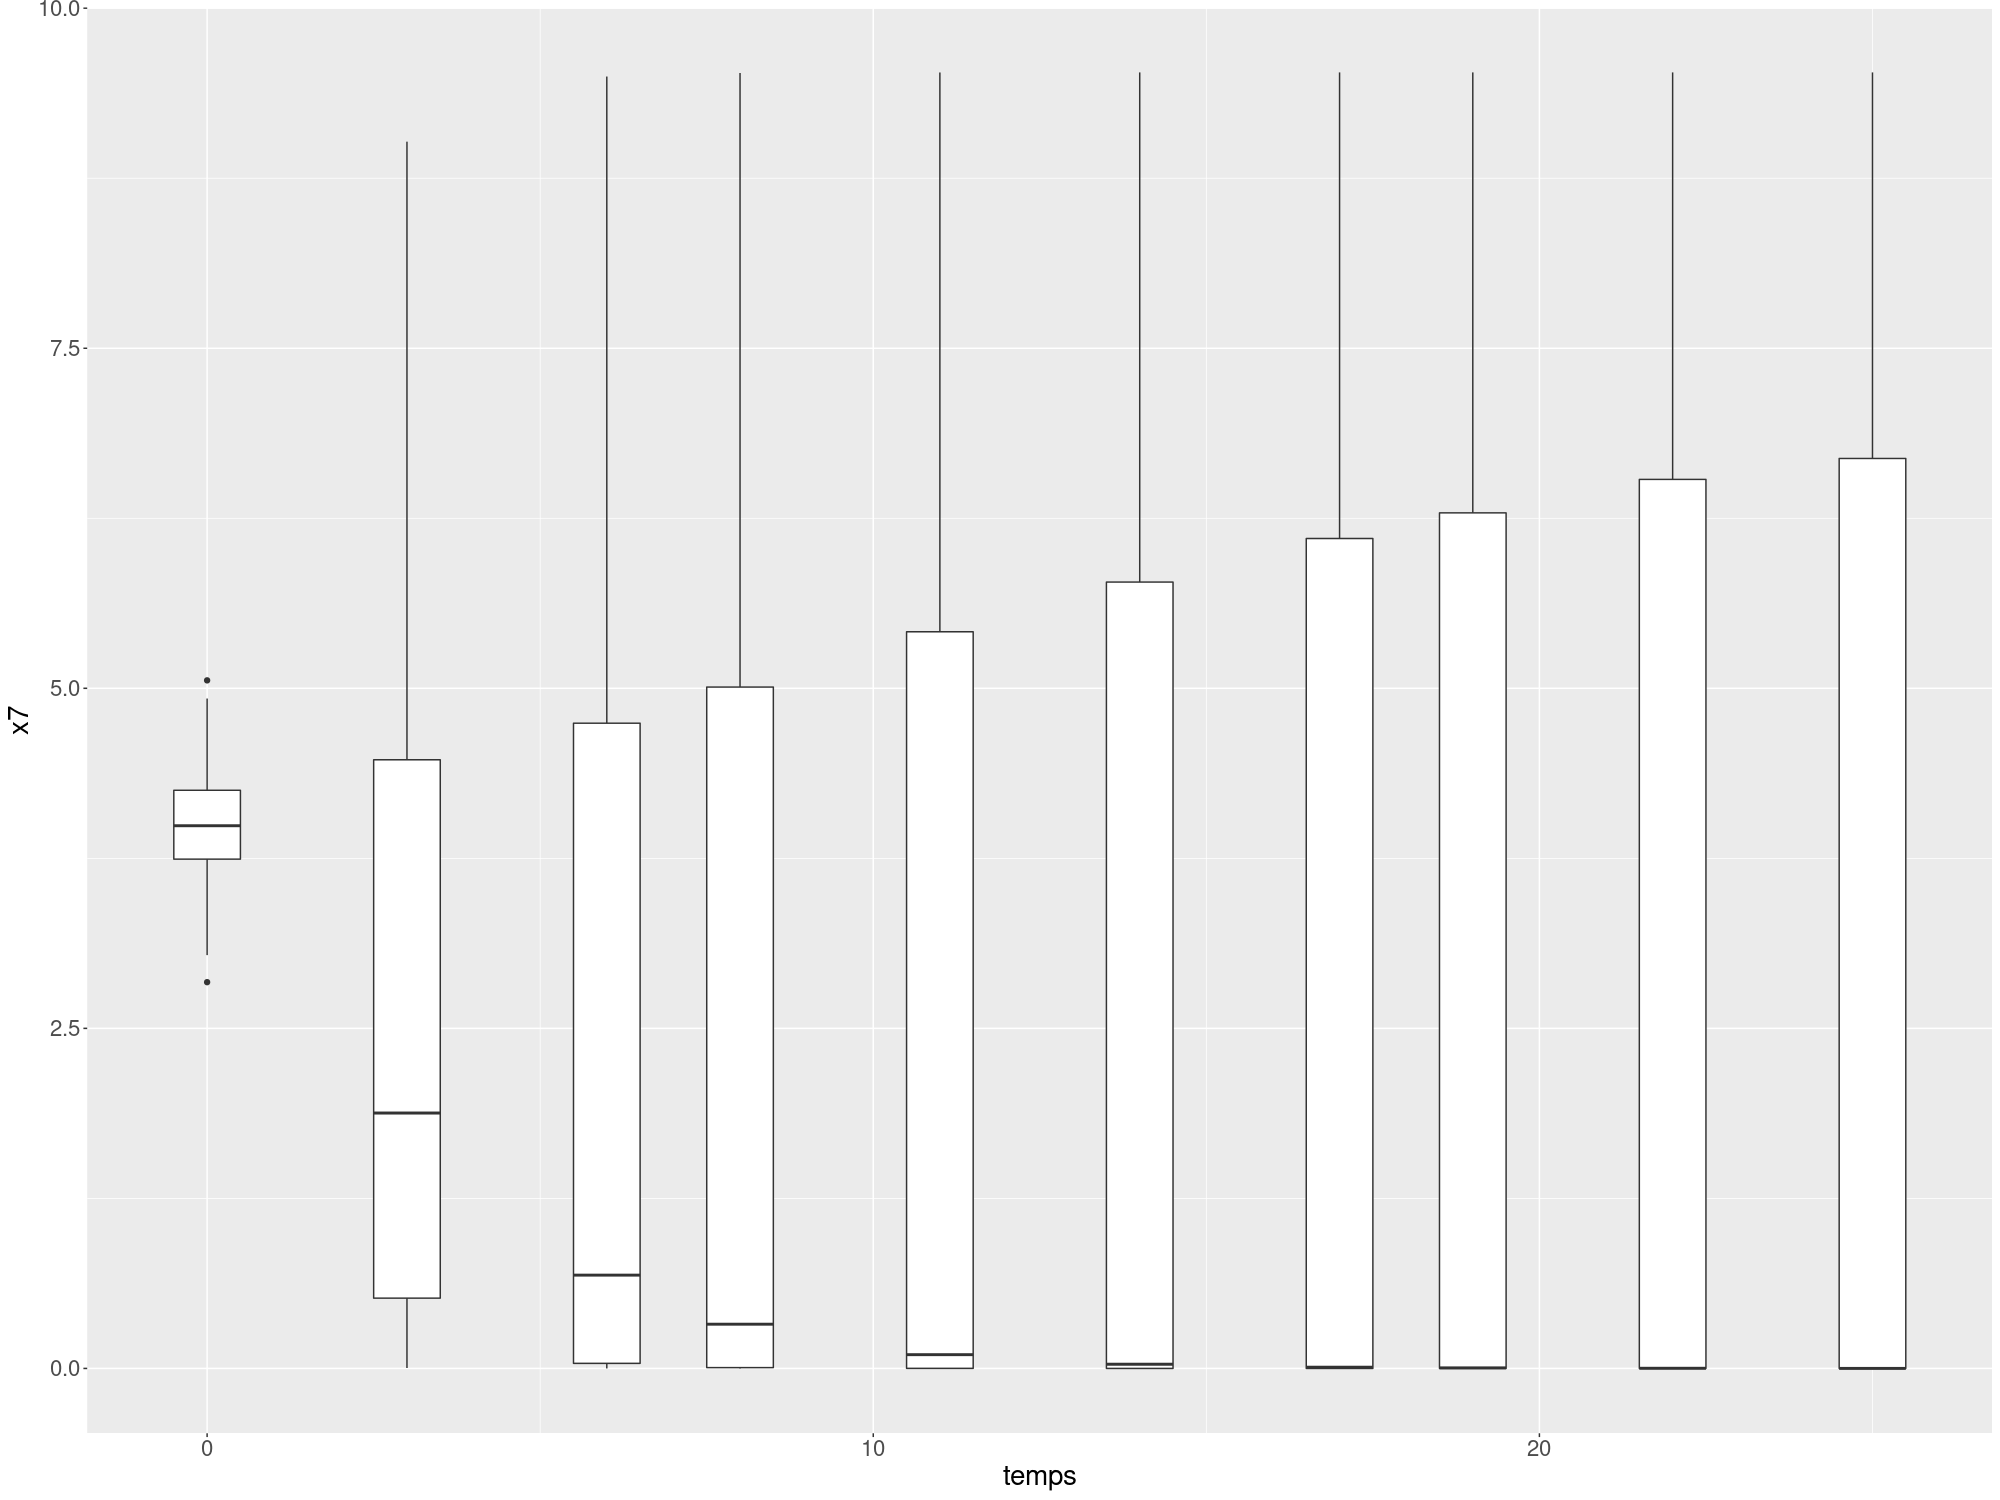

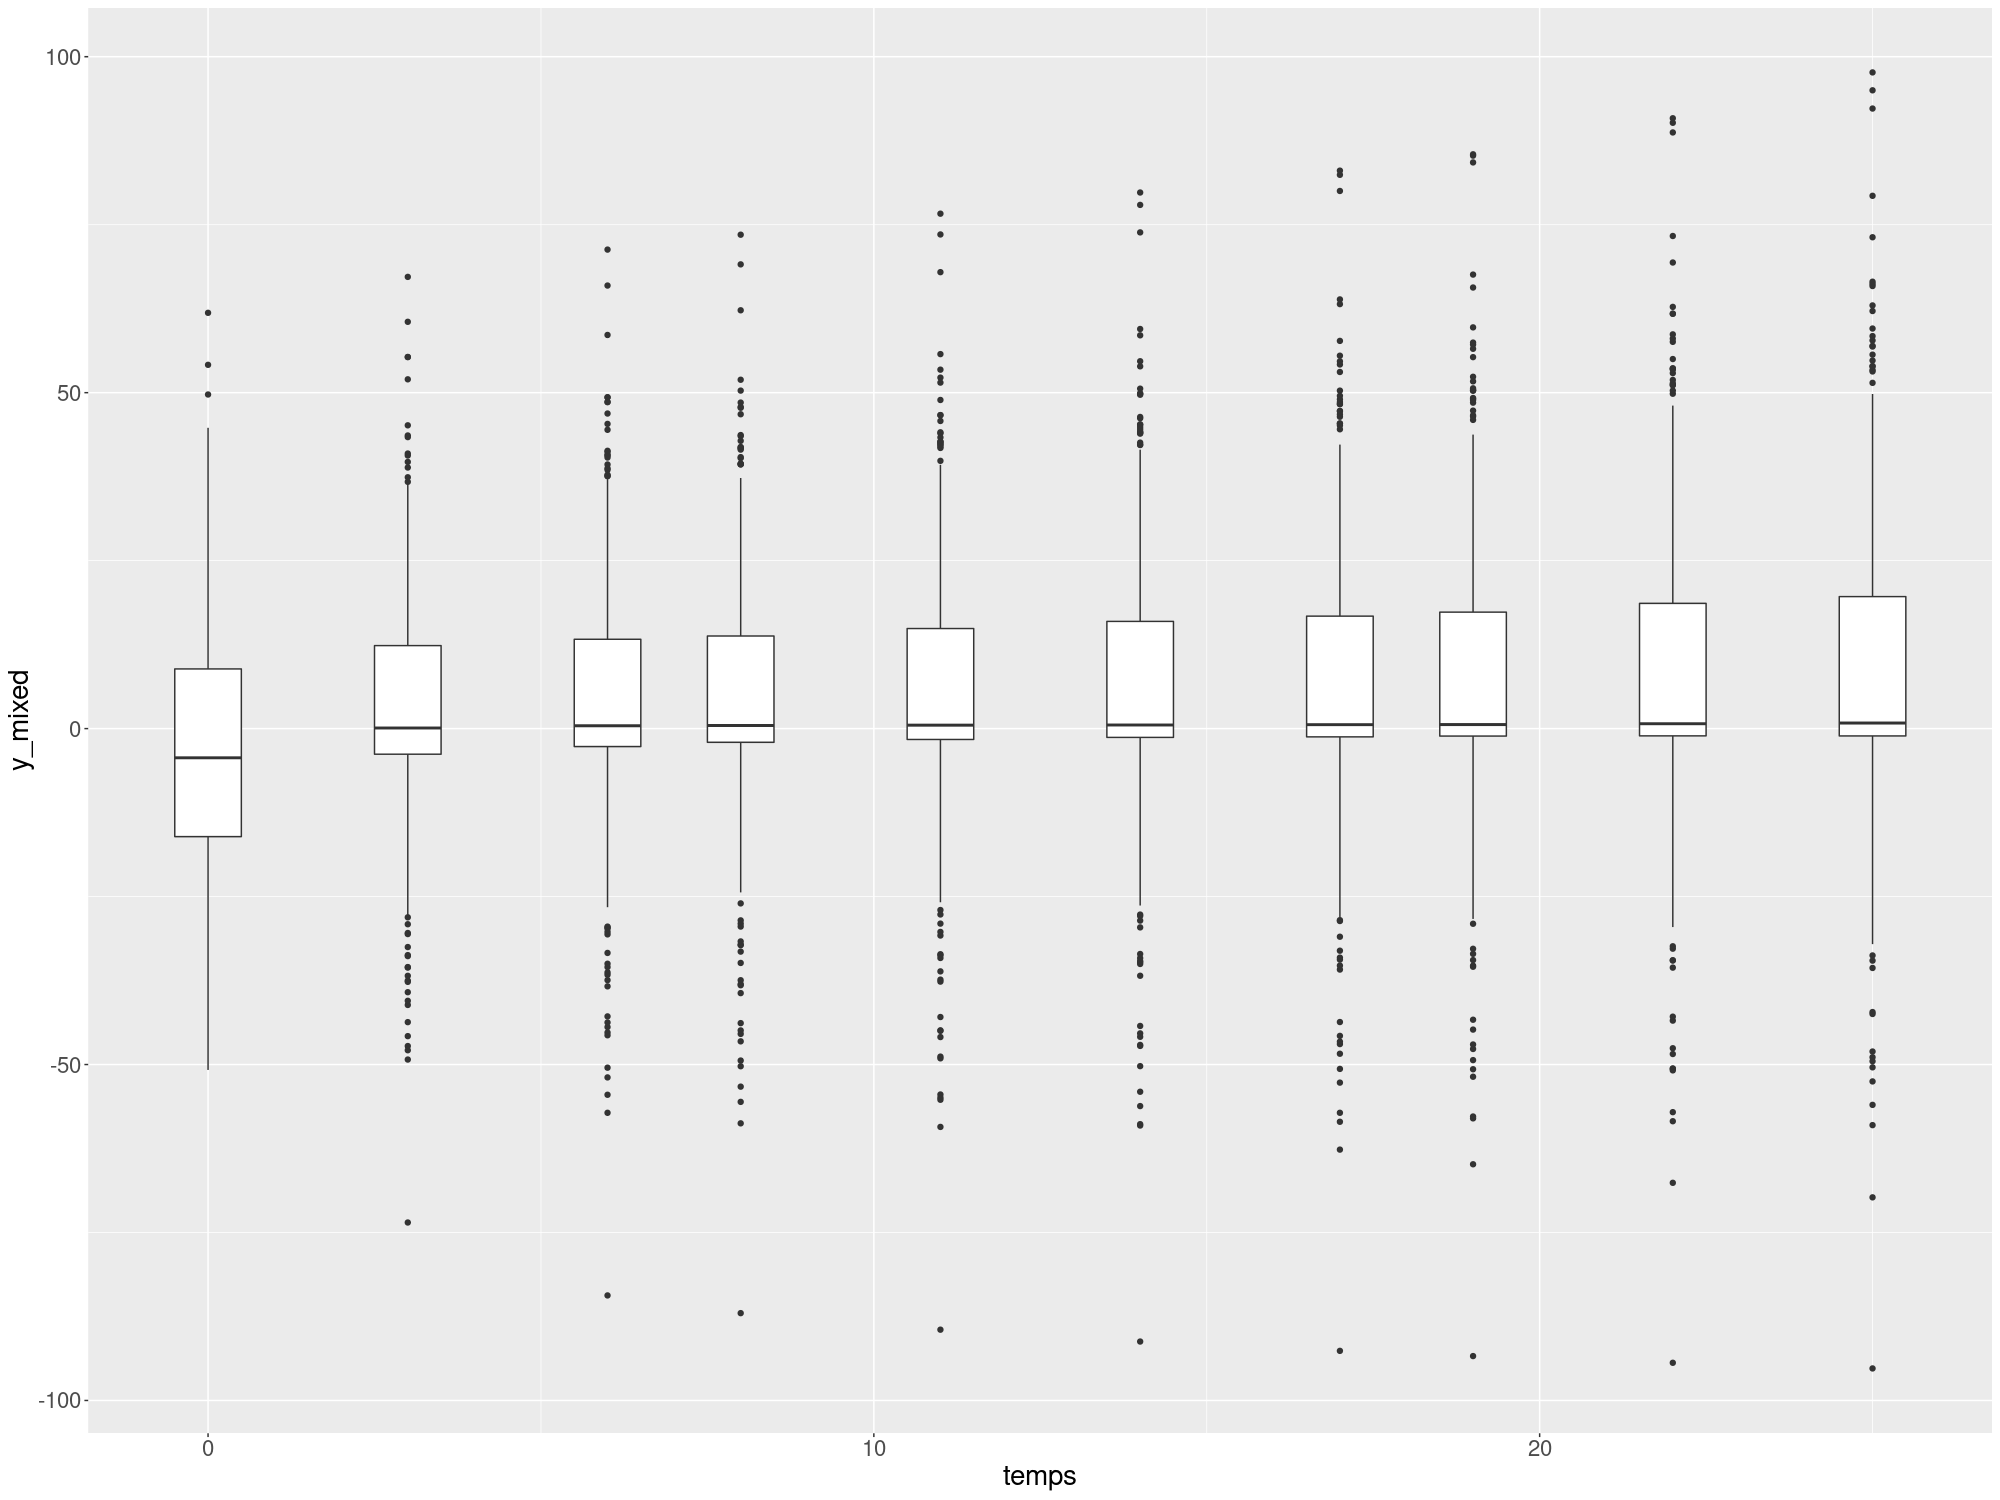

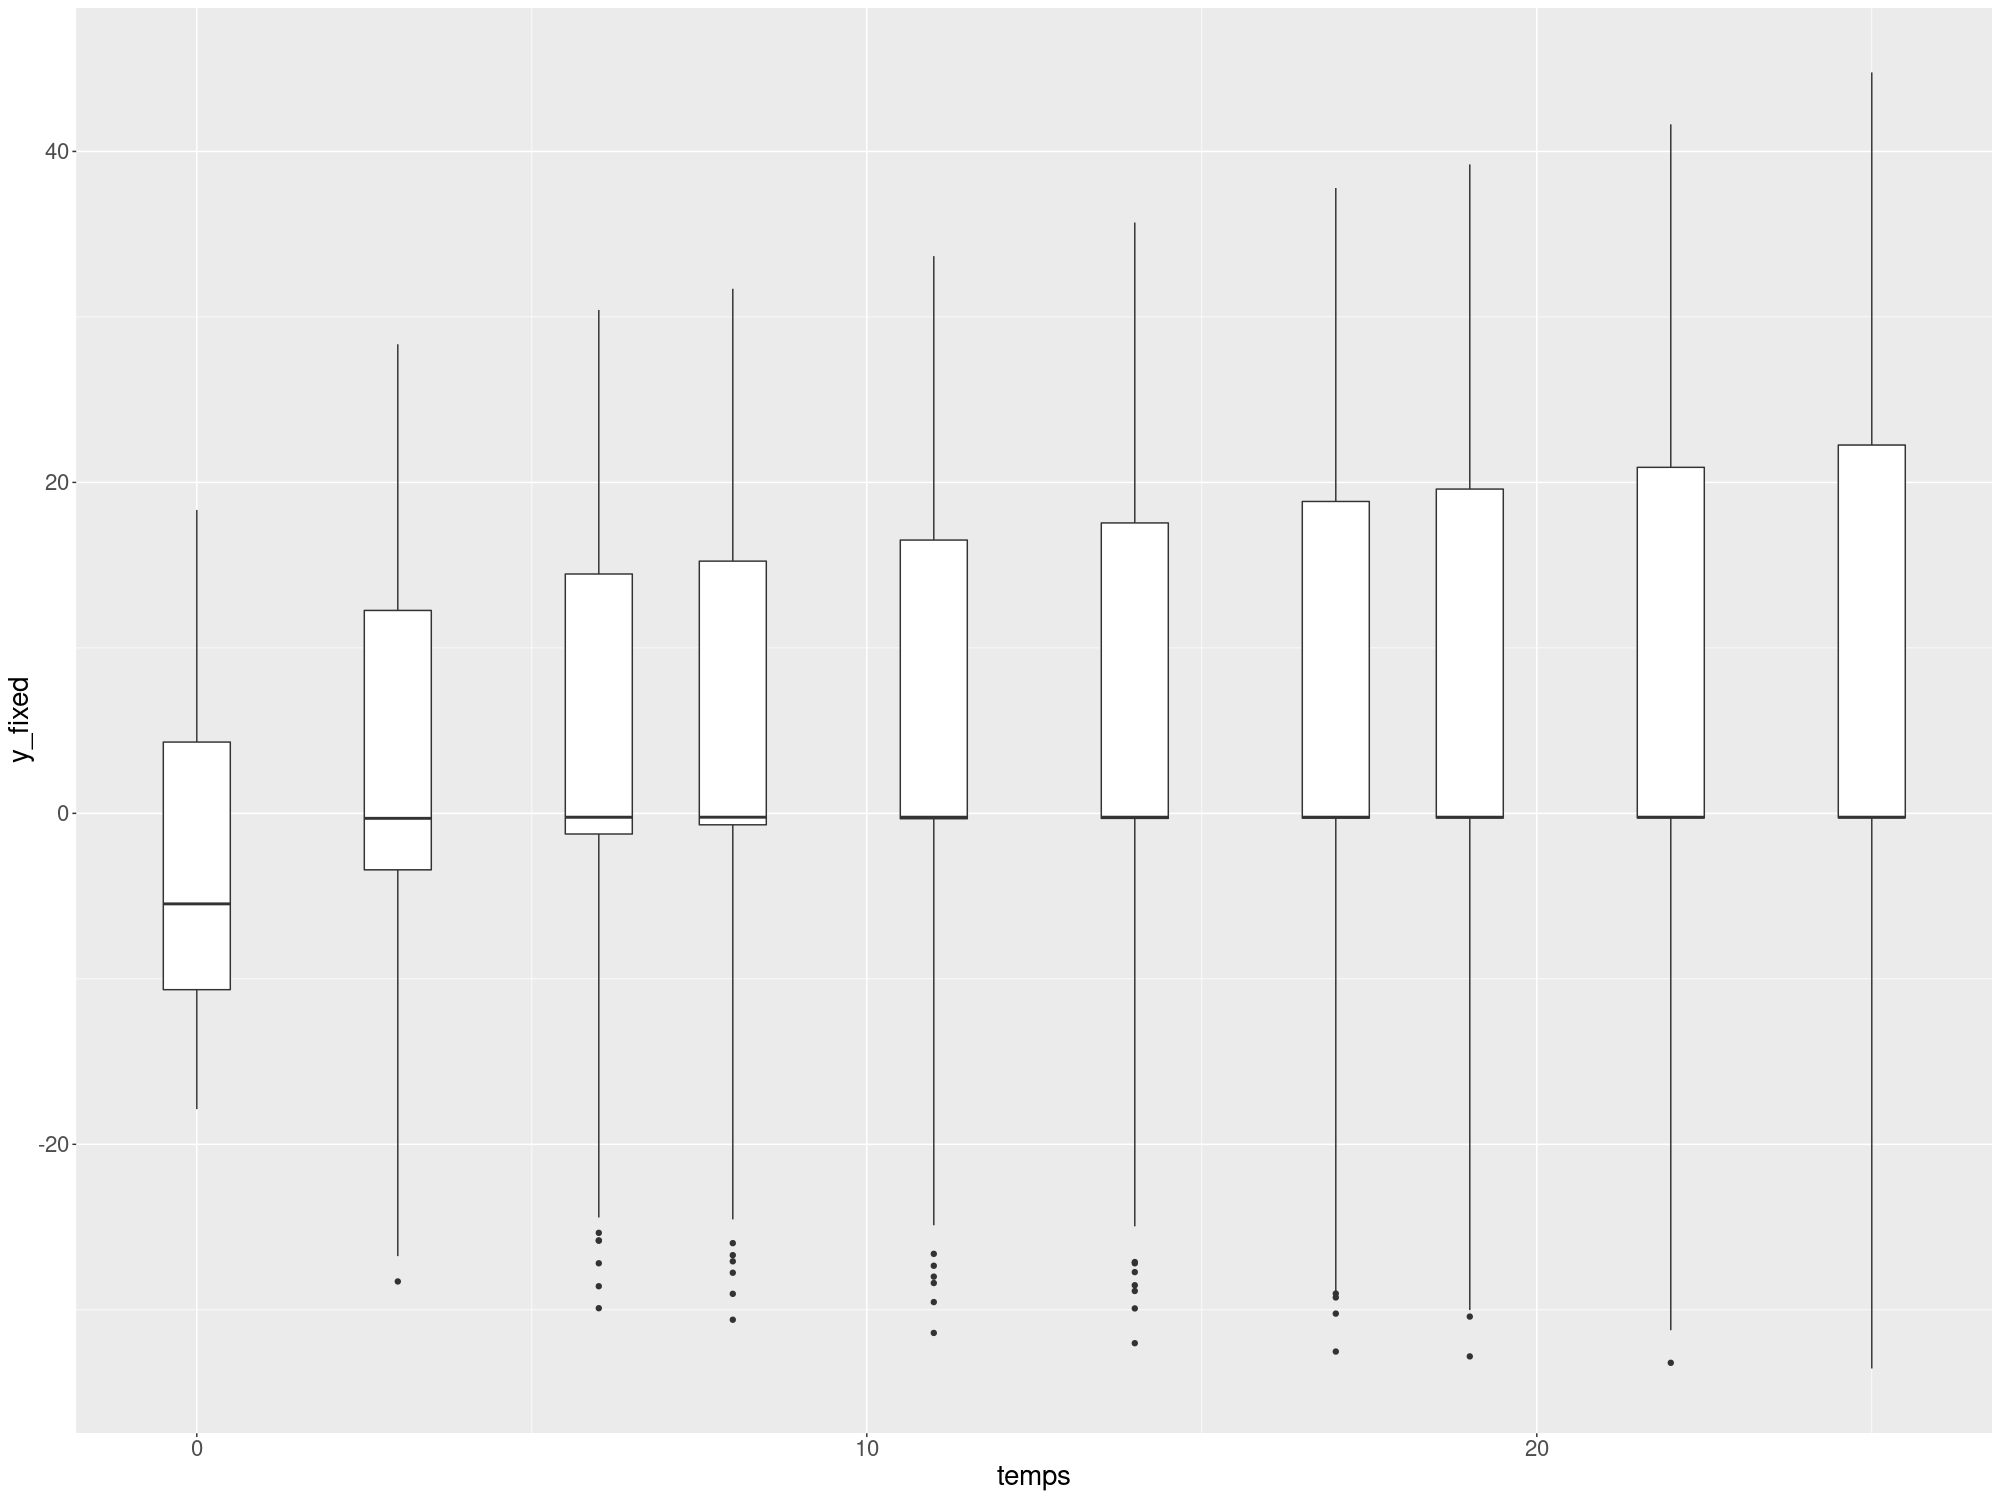

In [10]:
options(repr.plot.width = 20, repr.plot.height = 15, repr.plot.res = 100)


for (column_name in values_columns_nonoise) {
    print(
        ggplot(data_box, aes(group = temps, x = temps, y = .data[[column_name]])) +
            geom_boxplot(width = 1) +
            theme(text = element_text(size = 20), plot.title = element_text(size = 60, hjust = 0.5))
    )
}


## Spagetthi plots

We select 20 individuals including the two giving the maximal and minimal values for $y^*_{fixed}$.

In [11]:
N_spag <- 20

disp_ind_max <- aggregate(x = data$y_fixed, by = list(data$individus), FUN = max)
disp_ind_max <- disp_ind_max[order(disp_ind_max$x), ]

disp_ind_min <- aggregate(x = data$y_fixed, by = list(data$individus), FUN = min)
disp_ind_min <- disp_ind_min[order(disp_ind_min$x), ]

disp_idx <- round(seq(1, length(disp_ind_min$x), length.out = round(N_spag / 2)))

disp_ind <- c(as.numeric(rownames(disp_ind_min)[disp_idx]), as.numeric(rownames(disp_ind_max)[disp_idx]))
disp_ind


[1] 177 461 131 125   7 124 410 346 296 480 481 167 103 353 113 178 408 420 446
[20]  56

In [12]:
data_temp <- data[data$individus %in% disp_ind, ]


spagetthi <- function(nonoise_colname, noise_colname='') {
    
    options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 100)

    plot1 <- ggplot(data_temp, aes(x = temps, .data[[nonoise_colname]], group = individus, color = individus)) +
    geom_line() +
    theme(text = element_text(size = 40), plot.title = element_text(size = 40, hjust = 0.5))
    
    if (noise_colname == '') {
        grid.arrange(plot1, ncol = 1)  

    } else {
        options(repr.plot.width = 40, repr.plot.height = 10, repr.plot.res = 100)

        plot2 <- ggplot(data_temp, aes(x = temps, .data[[noise_colname]], group = individus, color = individus)) +
            geom_line() +
            theme(text = element_text(size = 40), plot.title = element_text(size = 40, hjust = 0.5))


        grid.arrange(plot1, plot2, ncol = 2)
        }

}

$Y^*_{fixed,i} = \gamma_0 + 
\gamma_1 X^*_{2,i}(t) \cdot X^*_{5,i}(t) + 
\gamma_2 X^*_{4,i}(t) \cdot X^*_{7,i}(t) + 
\gamma_3 X^*_{6,i}(t) \cdot X^*_{8,i}(t)$


With:  
$\gamma_{k} \sim \mathcal{N}(0,\sigma_y^k)$ , $\sigma_y^0 = \sigma_y^1 = 0.5$ , $\sigma_y^2 = 0.05$

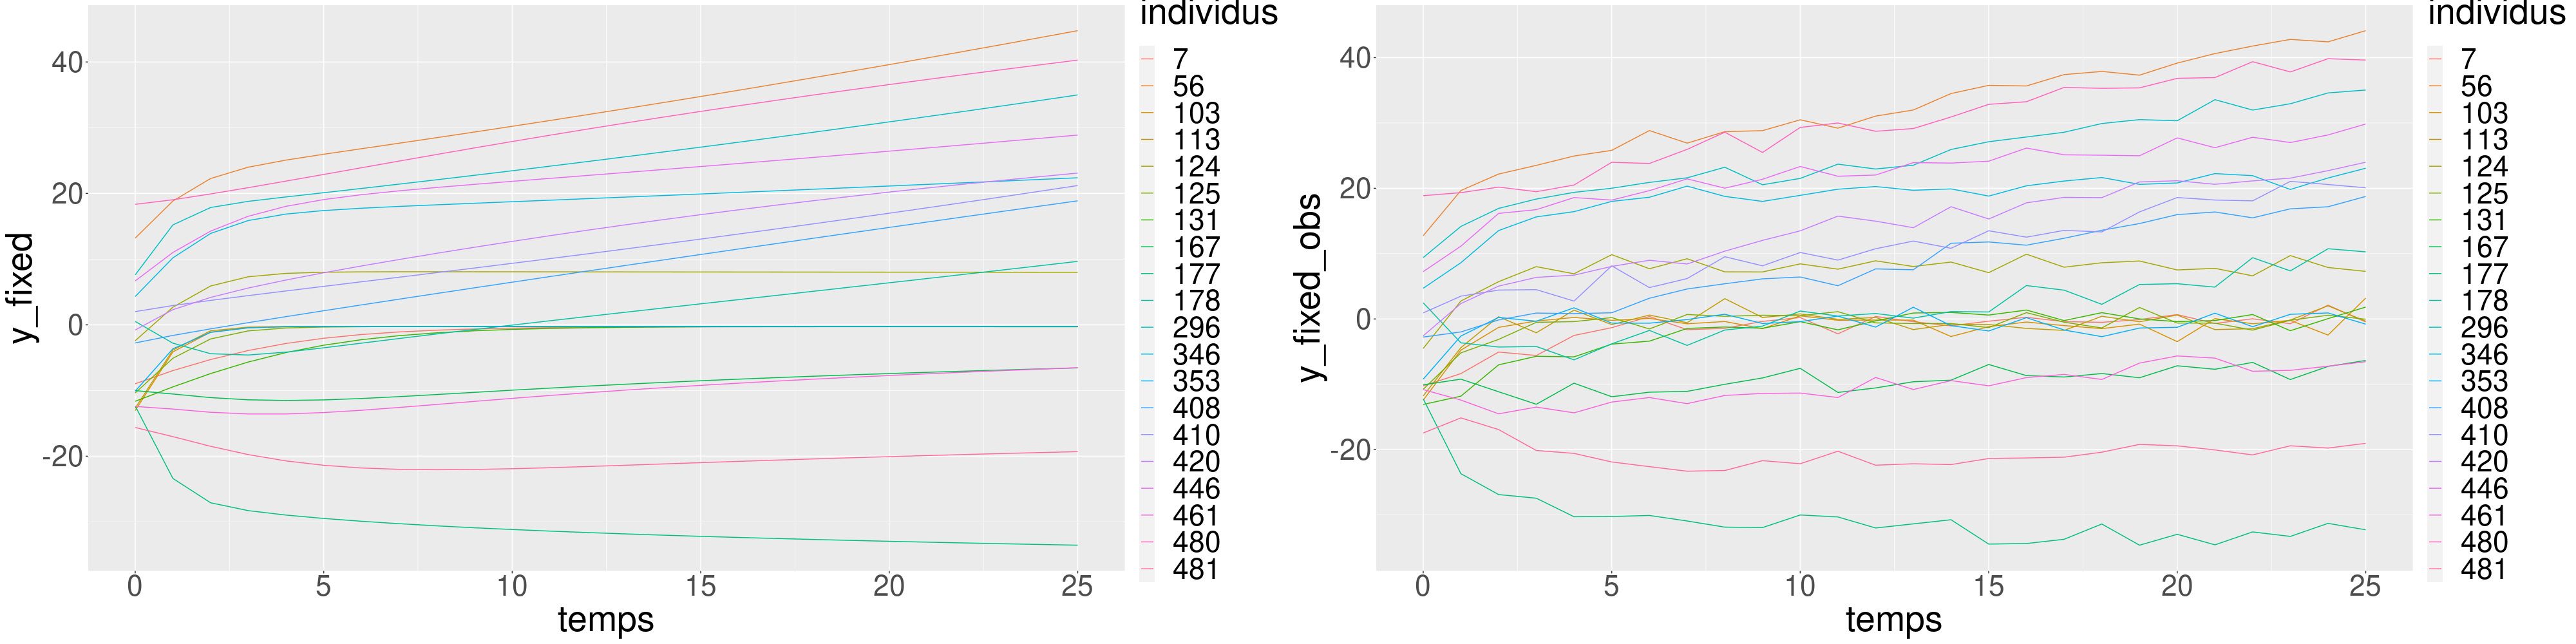

In [13]:
spagetthi('y_fixed', 'y_fixed_obs')

$Y^*_{mixed,i} = \gamma_{0,i} + 
\gamma_{1,i} X^*_{2,i}(t) \cdot X^*_{5,i}(t) + 
\gamma_{2,i} X^*_{4,i}(t) \cdot X^*_{7,i}(t) + 
\gamma_{3,i} X^*_{6,i}(t) \cdot X^*_{8,i}(t)$

With:  
$\gamma_{k,i} \sim \mathcal{N}(0,\sigma_y^k)$ , $\sigma_y^0 = \sigma_y^1 = 0.5$ , $\sigma_y^2 = 0.05$


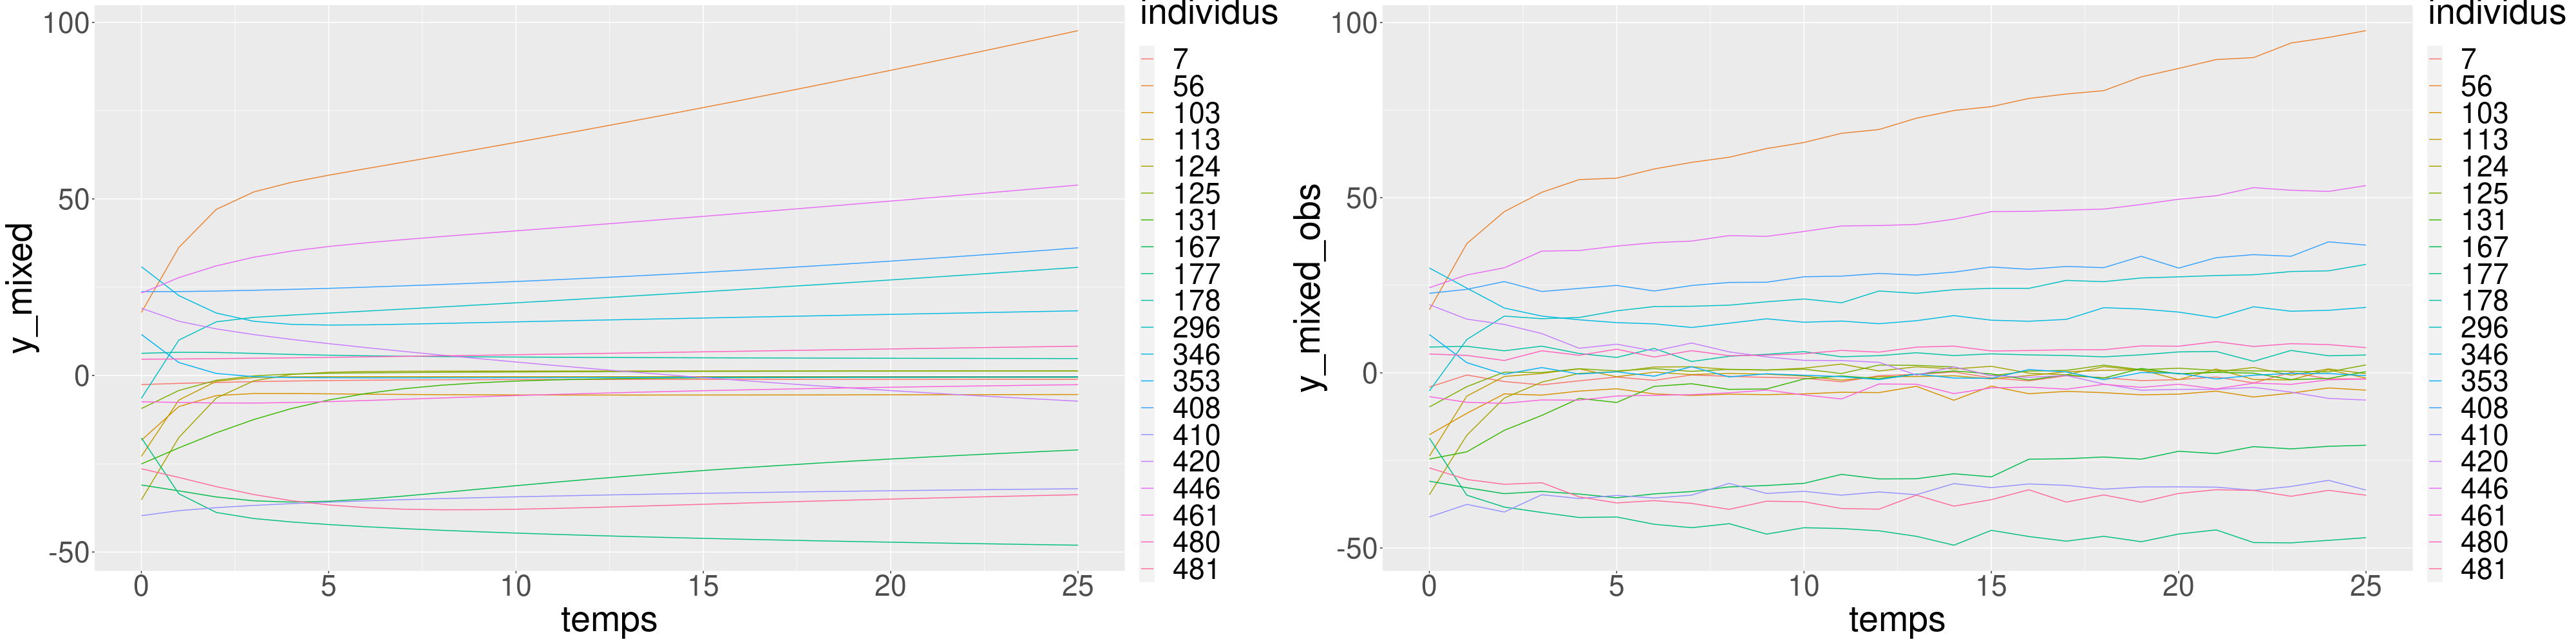

In [14]:
spagetthi('y_mixed', 'y_mixed_obs')

$X^*_{2,i}(t) \cdot X^*_{5,i}(t)$

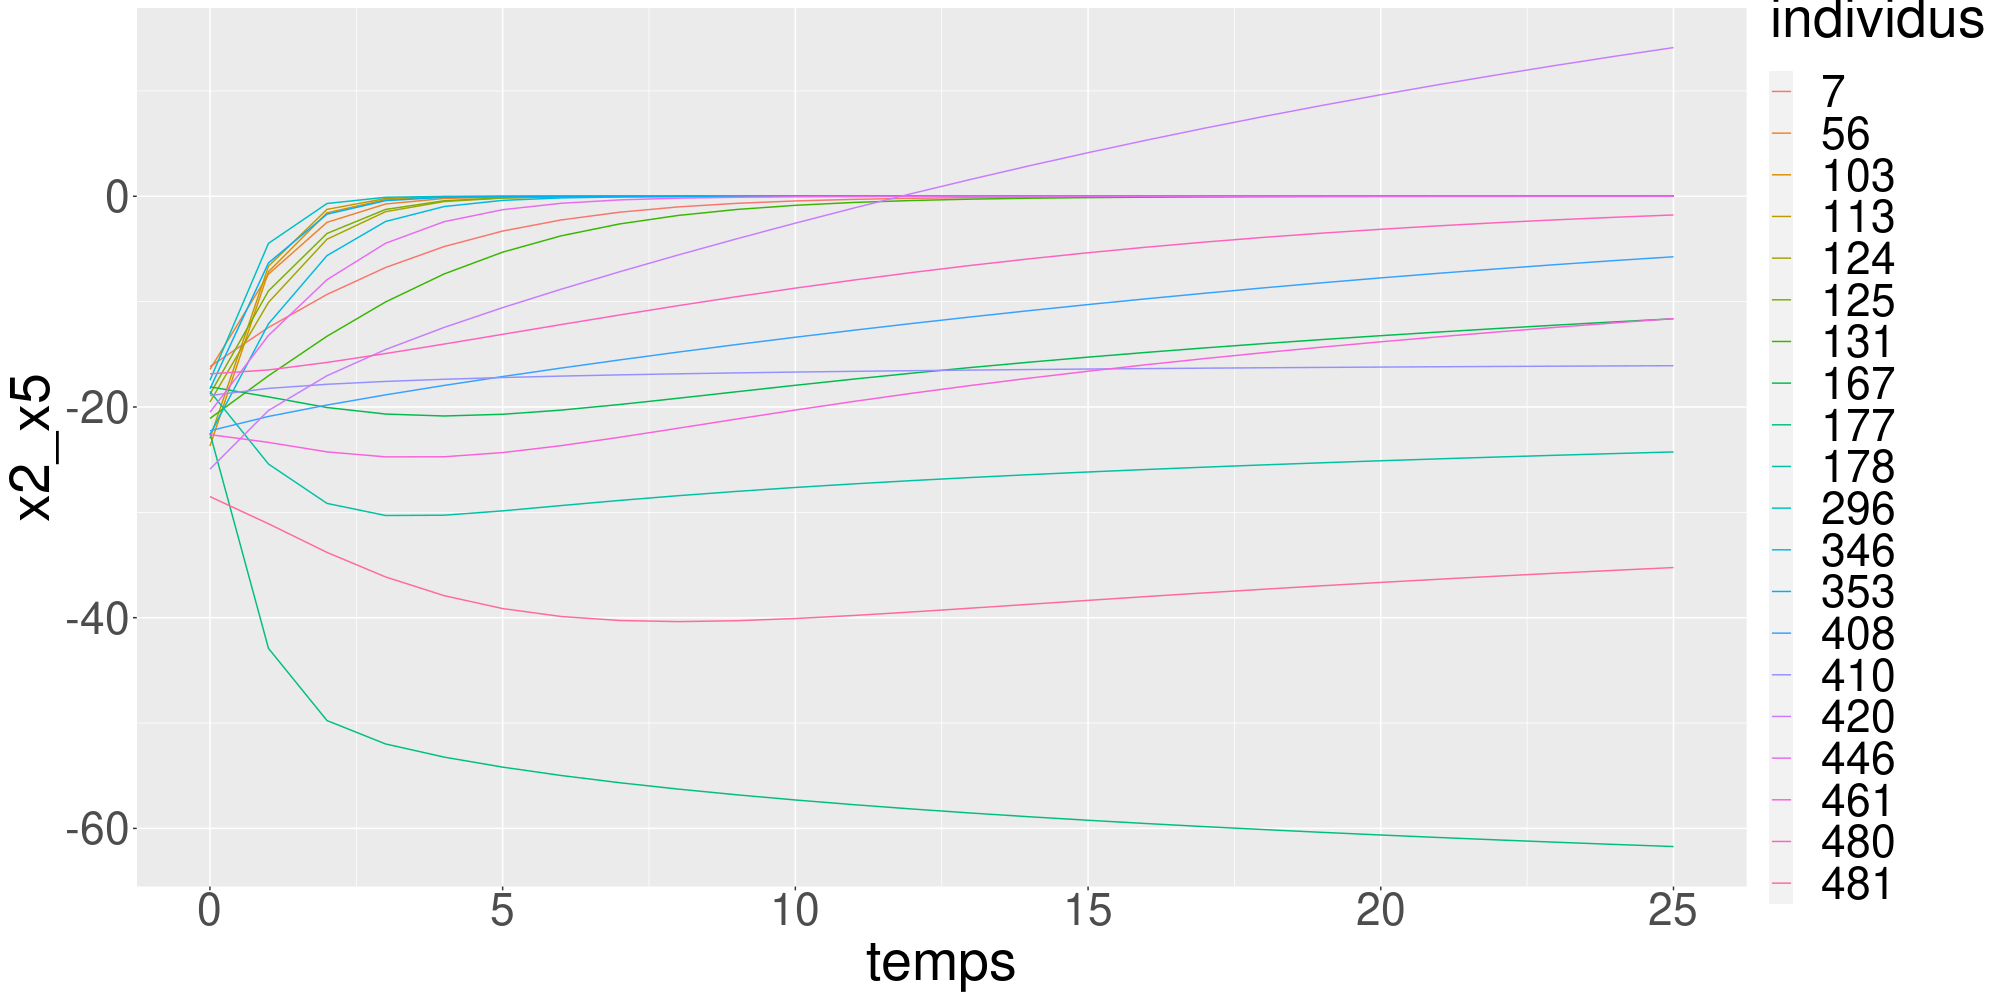

In [15]:
spagetthi('x2_x5')

$X^*_{4,i}(t) \cdot X^*_{7,i}(t)$

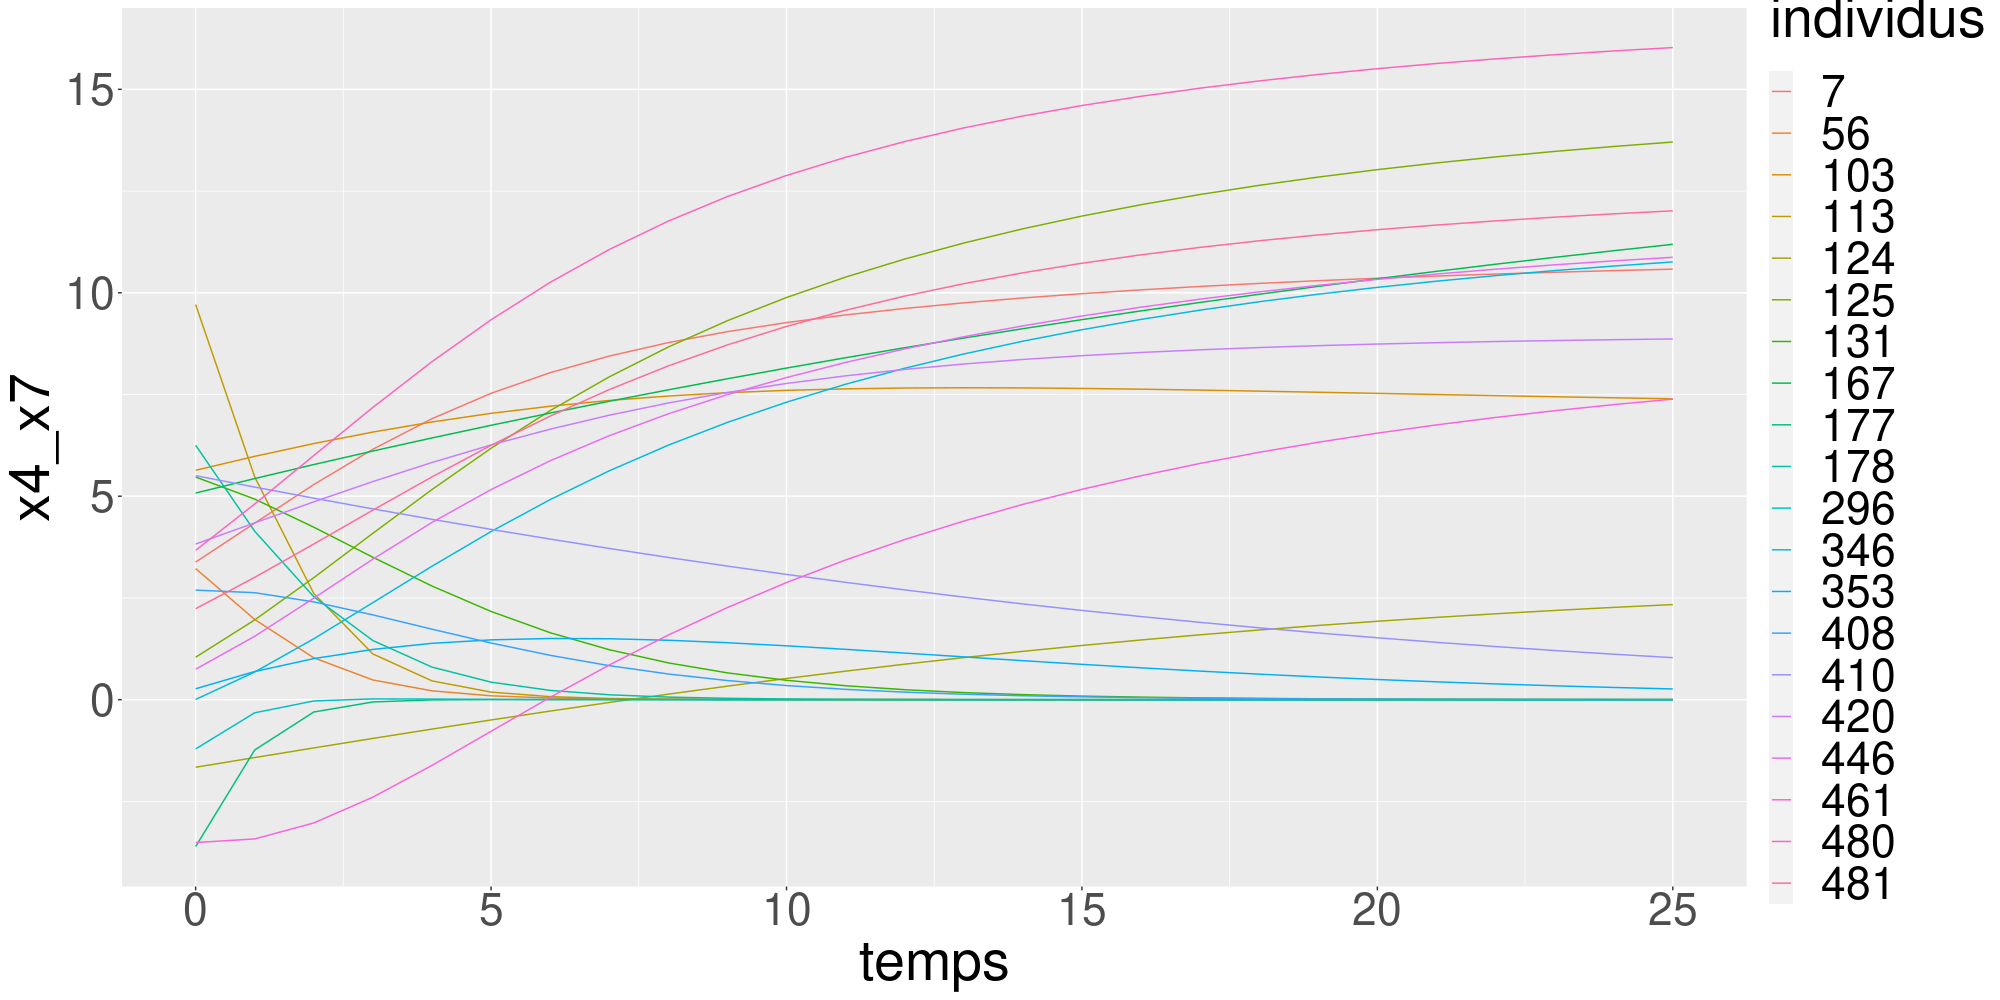

In [16]:
spagetthi('x4_x7')

$X^*_{6,i}(t) \cdot X^*_{8,i}(t)$

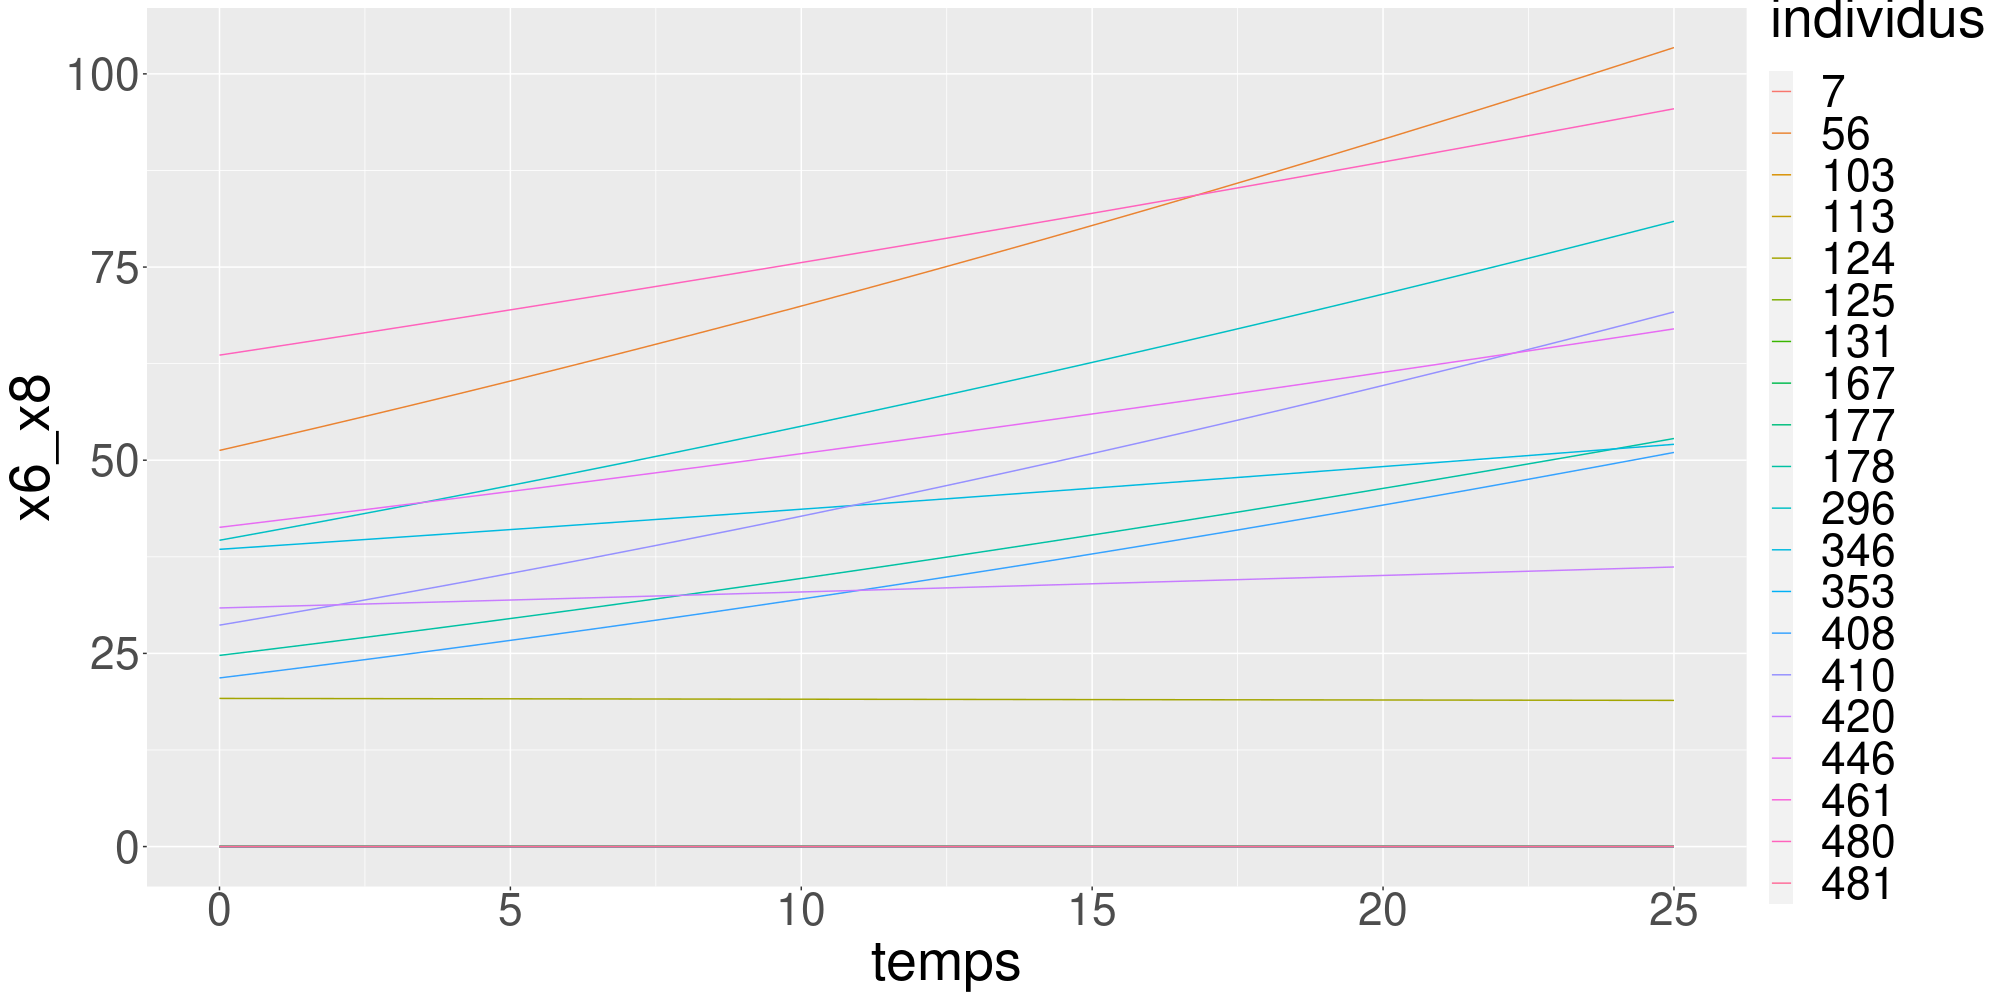

In [17]:
spagetthi('x6_x8')

$X^*_{1,i}(t) = \alpha_{0i}^1 + \alpha_{1,i}^1 t$

With:  
$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  

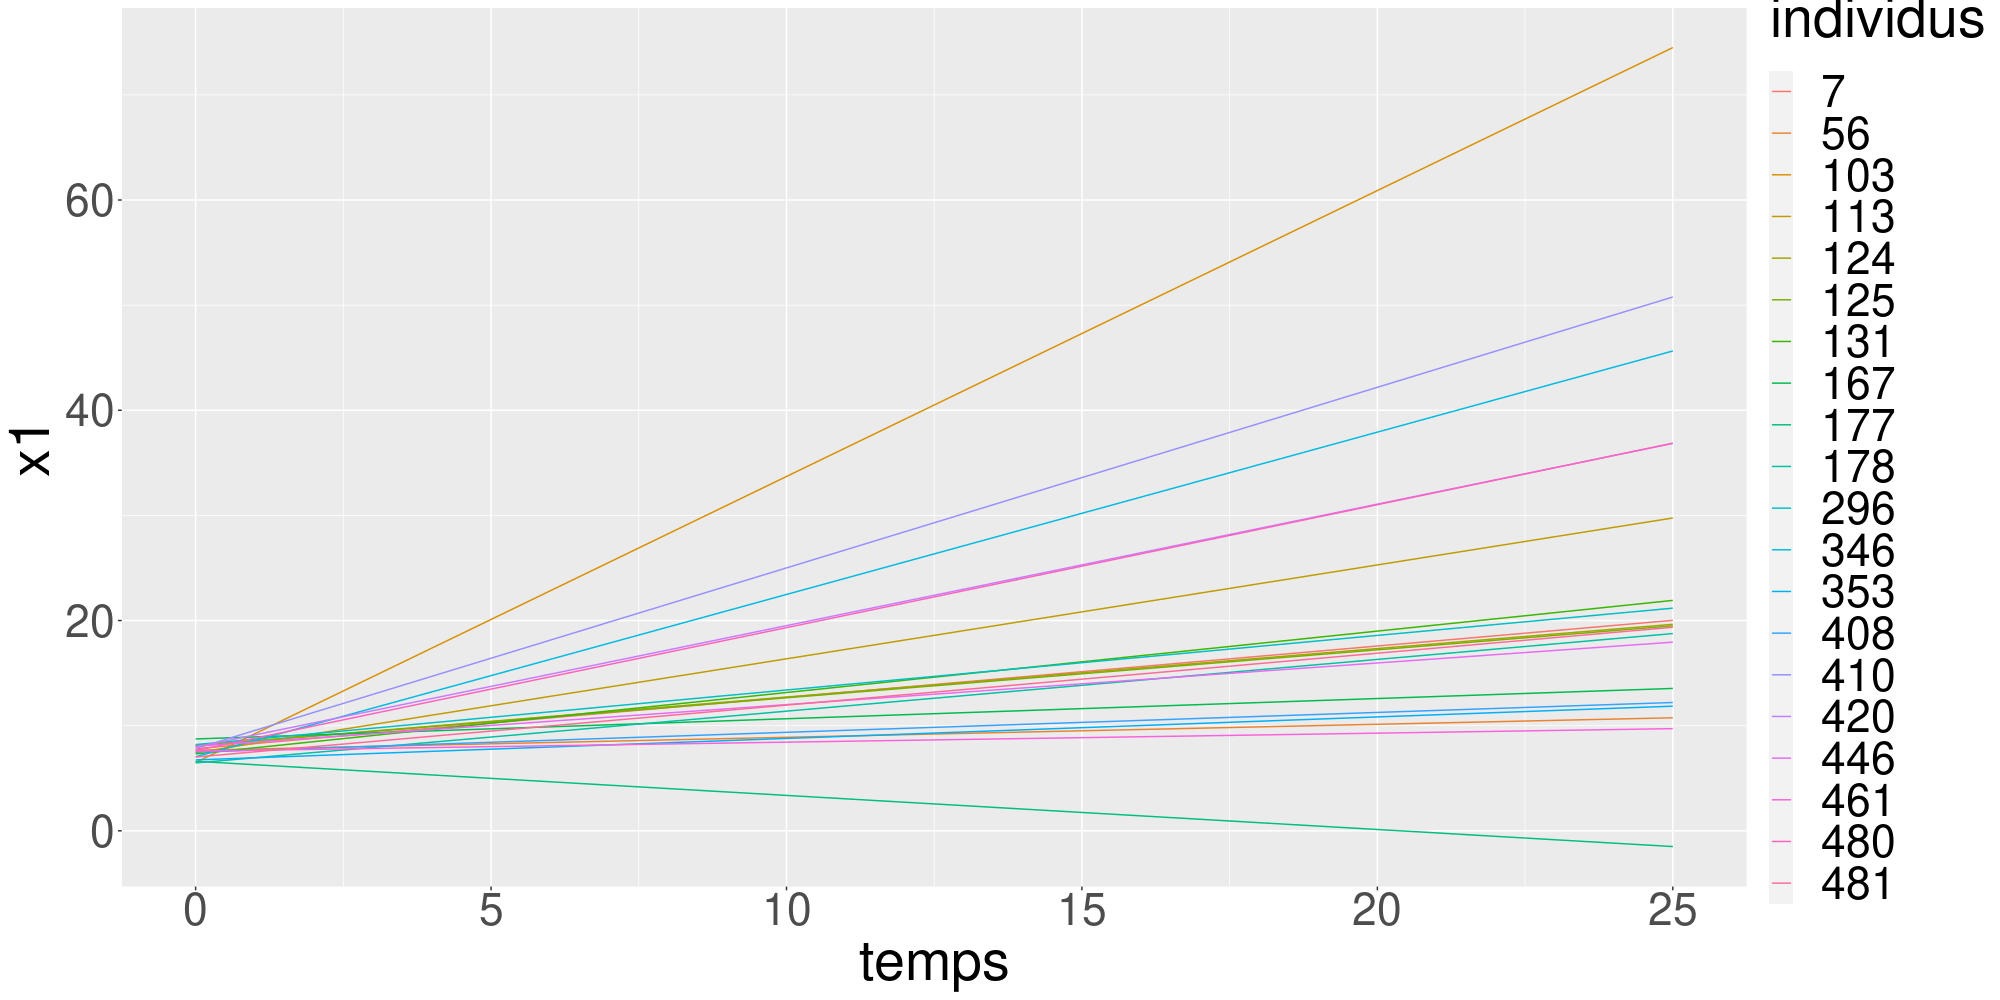

In [18]:
spagetthi('x1')

$X^*_{2,i}(t) = \alpha_{0i}^2 + \alpha_{1,i}^2 log(t+1)$

With:  

$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  

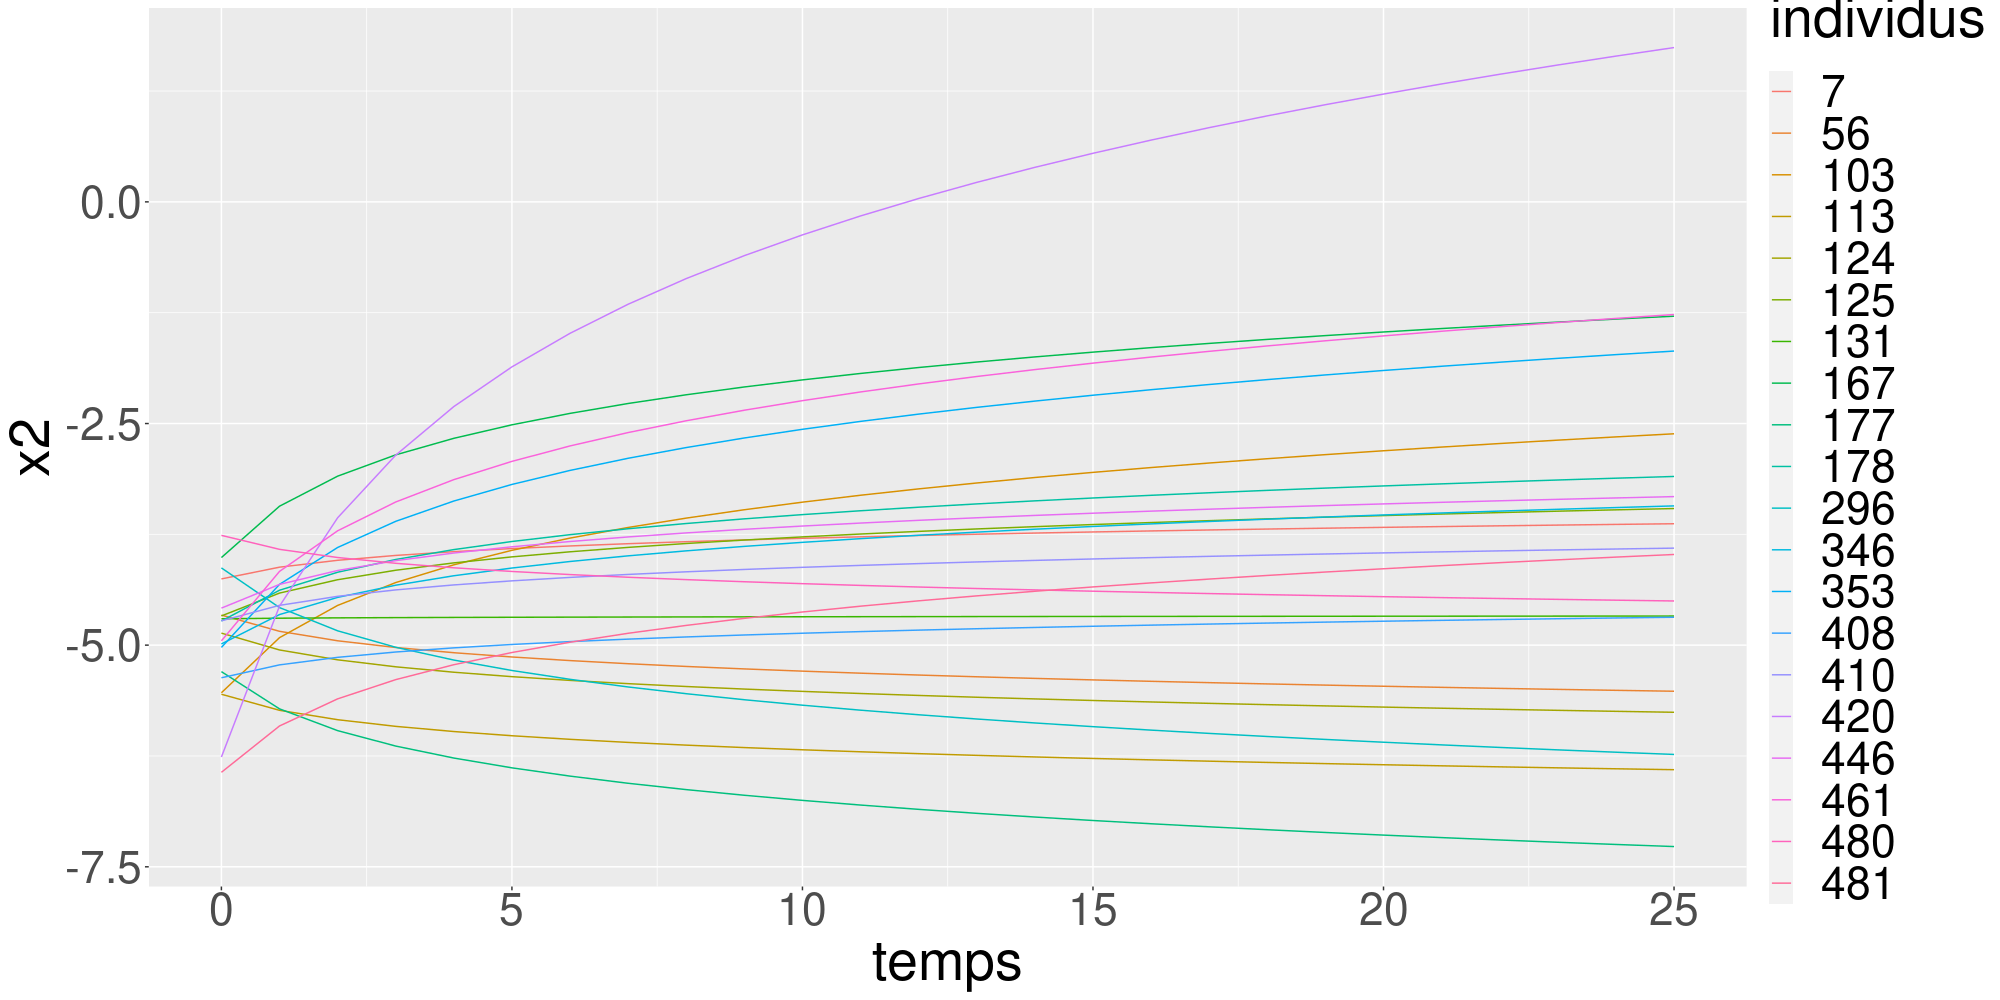

In [19]:
spagetthi('x2')

$X^*_{3,i}(t) = \alpha_{0i}^3 + \alpha_{1,i}^3 t^2$

With:  
$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  

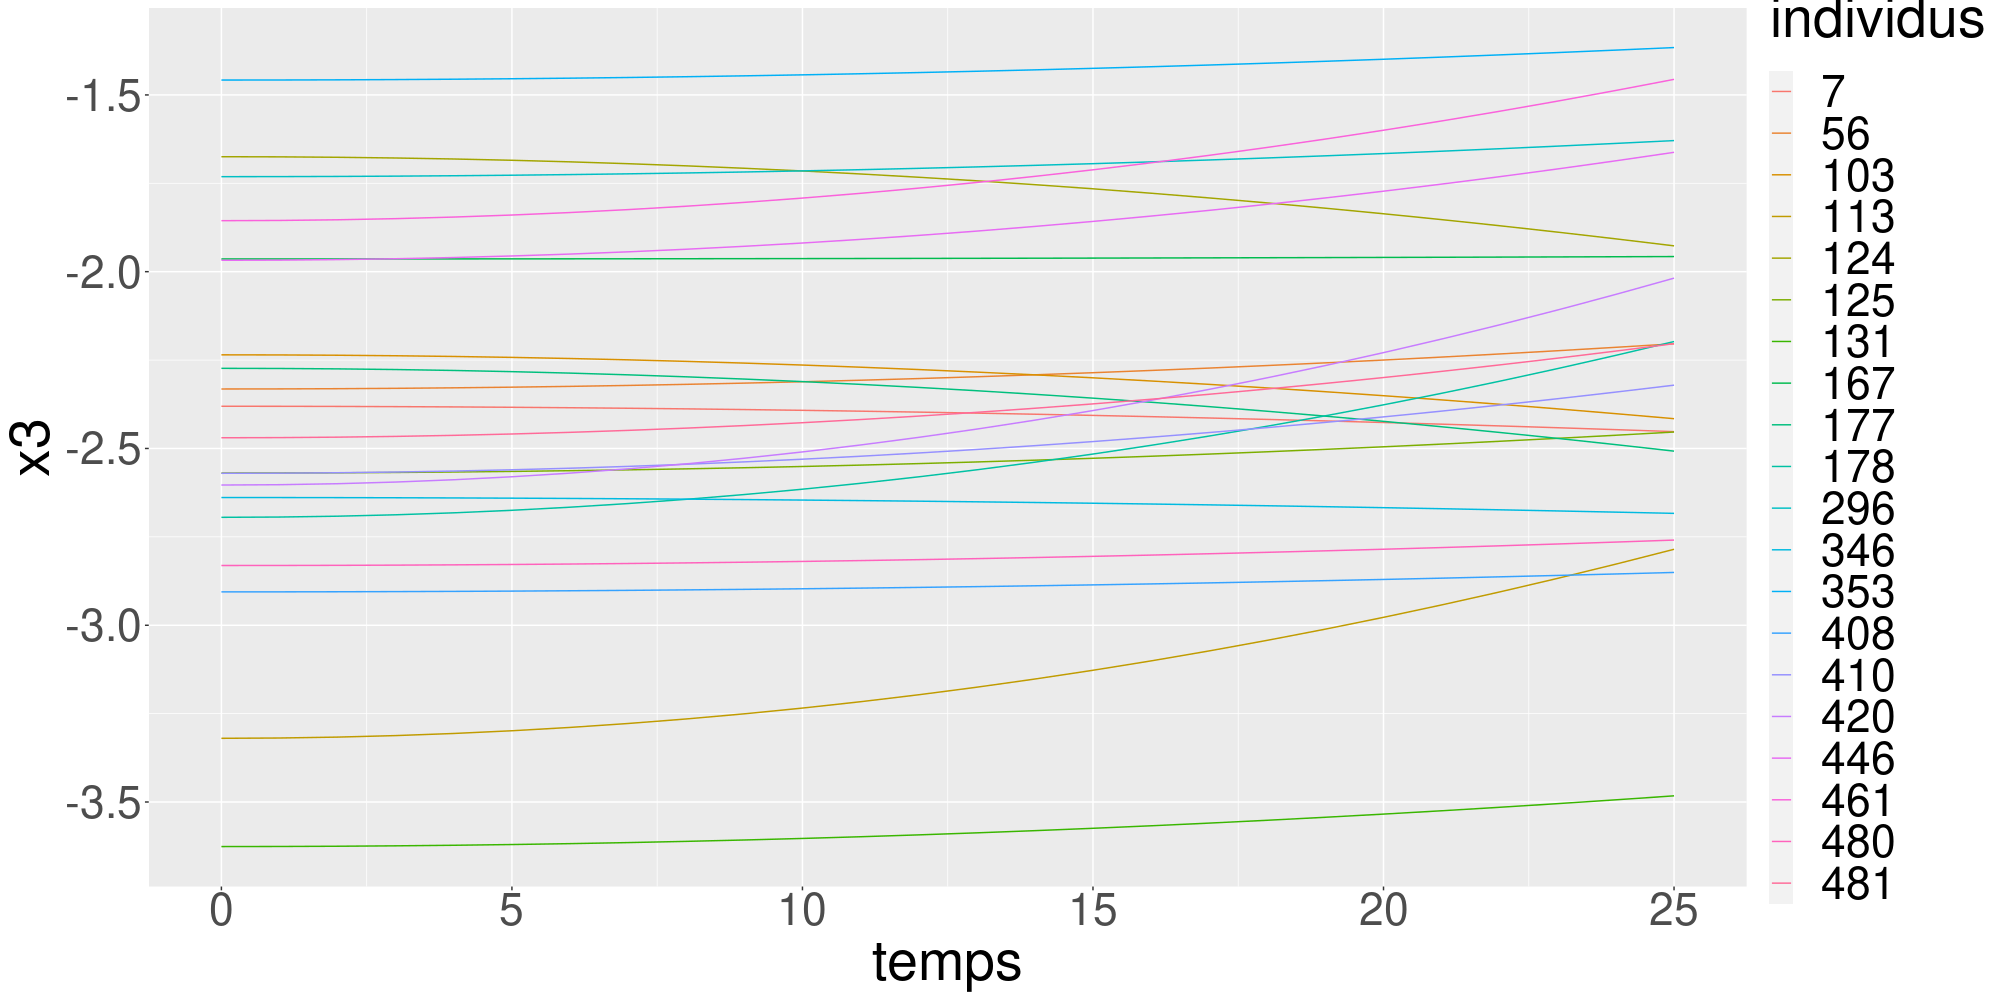

In [20]:
spagetthi('x3')

$X^*_{4,i}(t) = \alpha_{0i}^4 + \alpha_{1,i}^4 e^{-0.1t}$

With:  

$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  

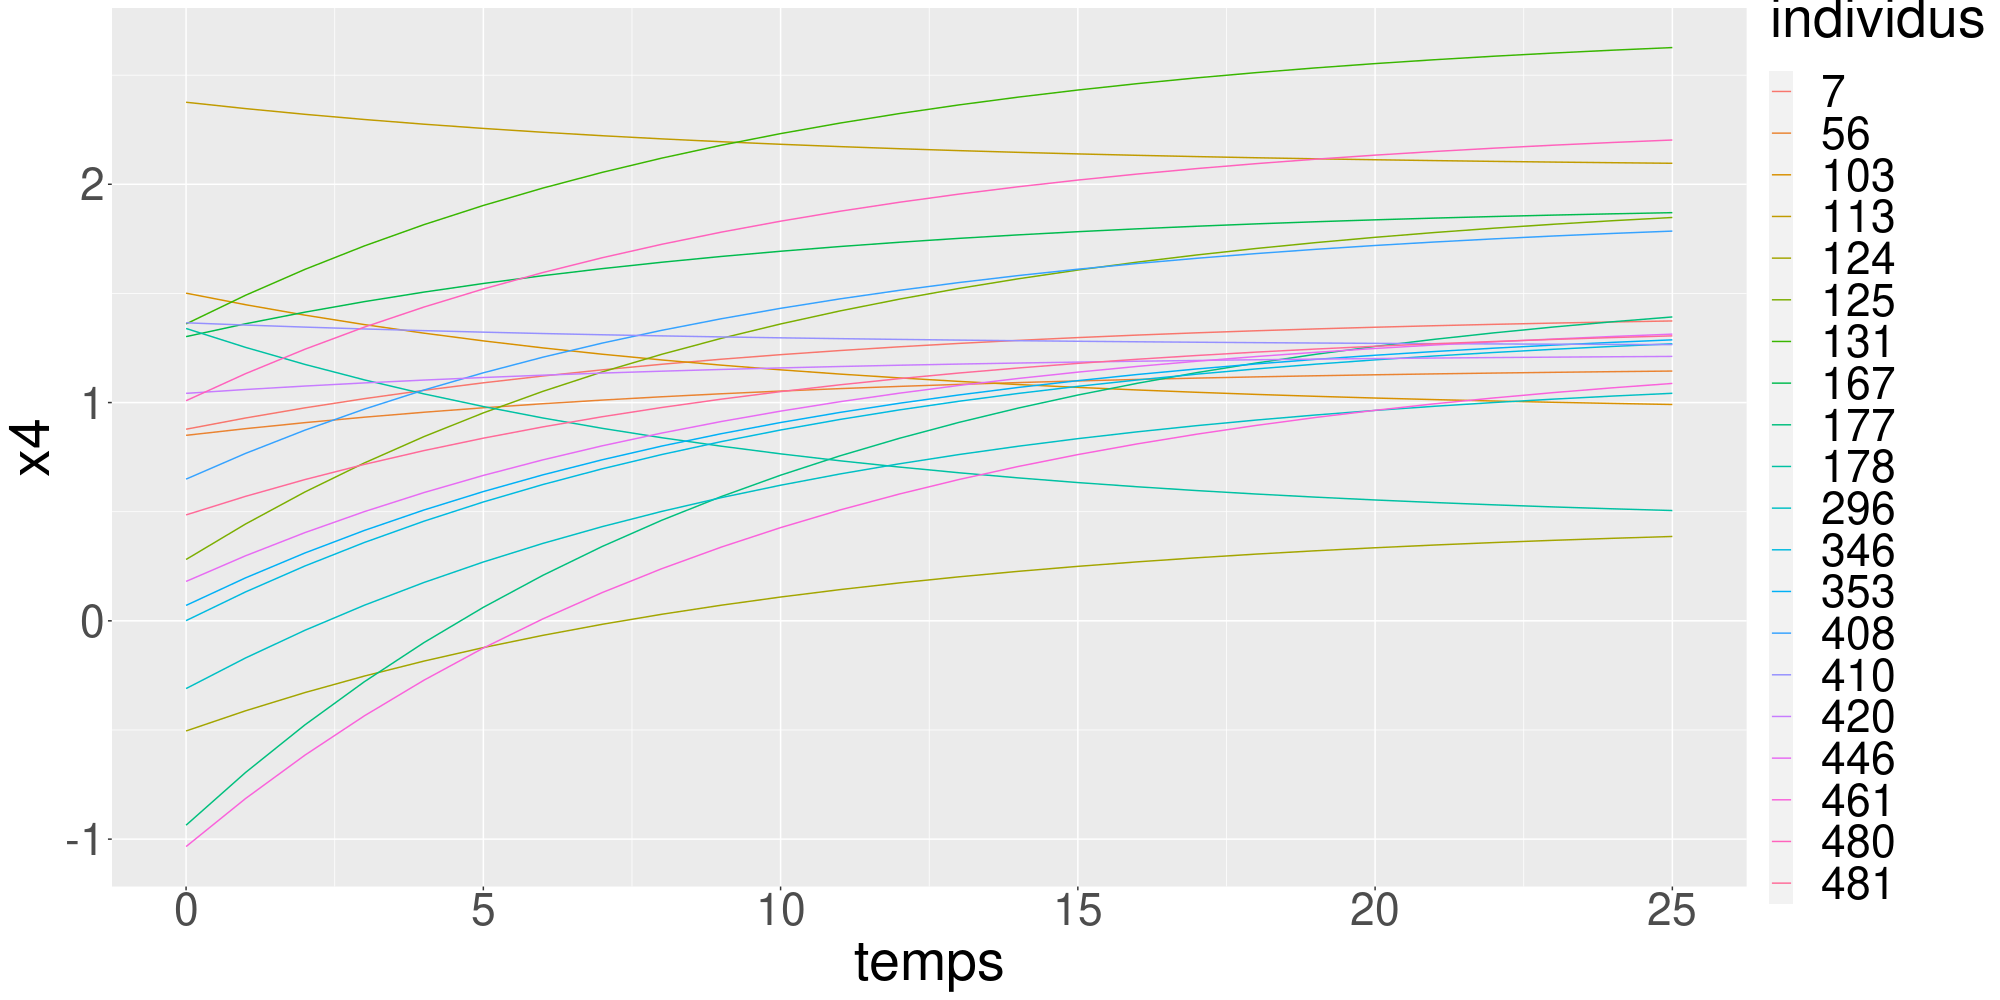

In [21]:
spagetthi('x4')

$X^*_{5,i}(t) = \frac{\alpha_{0,i}^5}{1+e^{-\alpha_{1,i}^5 t}}$

With:  

$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  

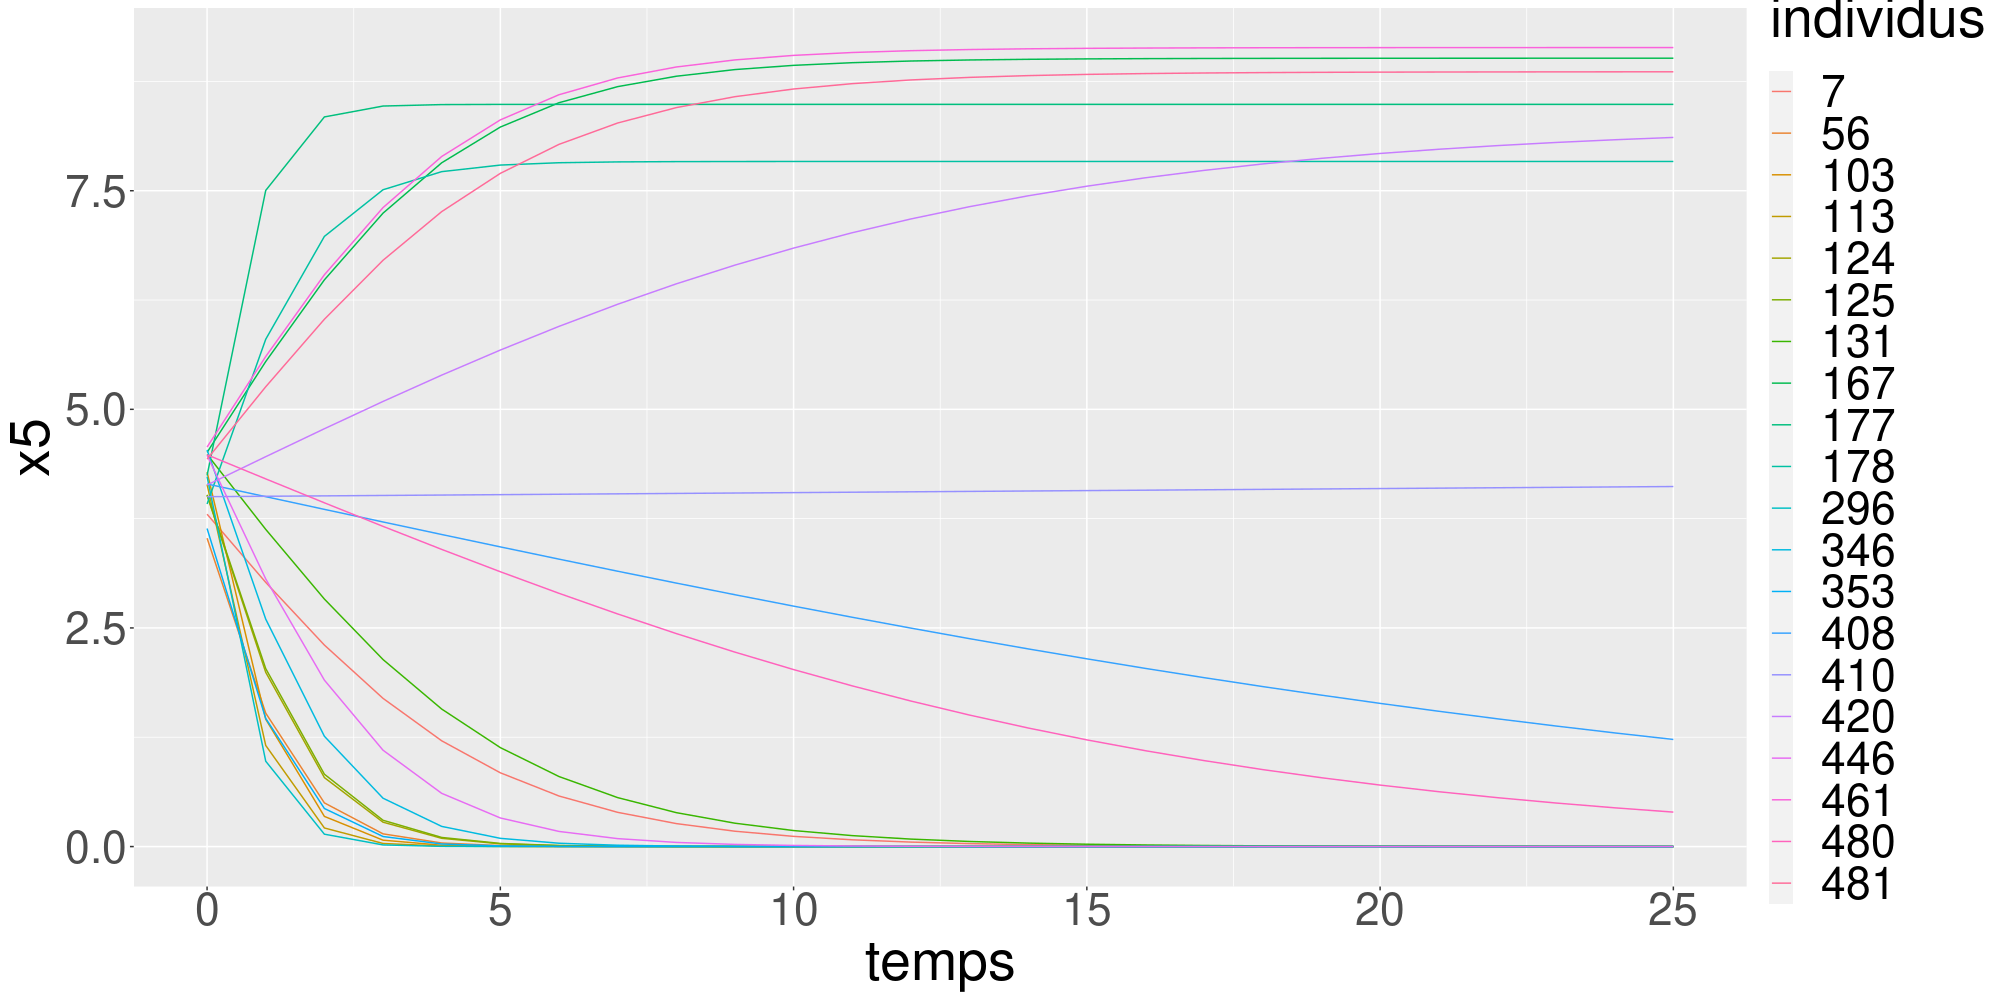

In [22]:
spagetthi('x5')

$X^*_{6,i}(t) = max(0, \alpha_{0,i}^6 + 0.1*\alpha_{1,i}^6 + t^2)$

With:  

$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  

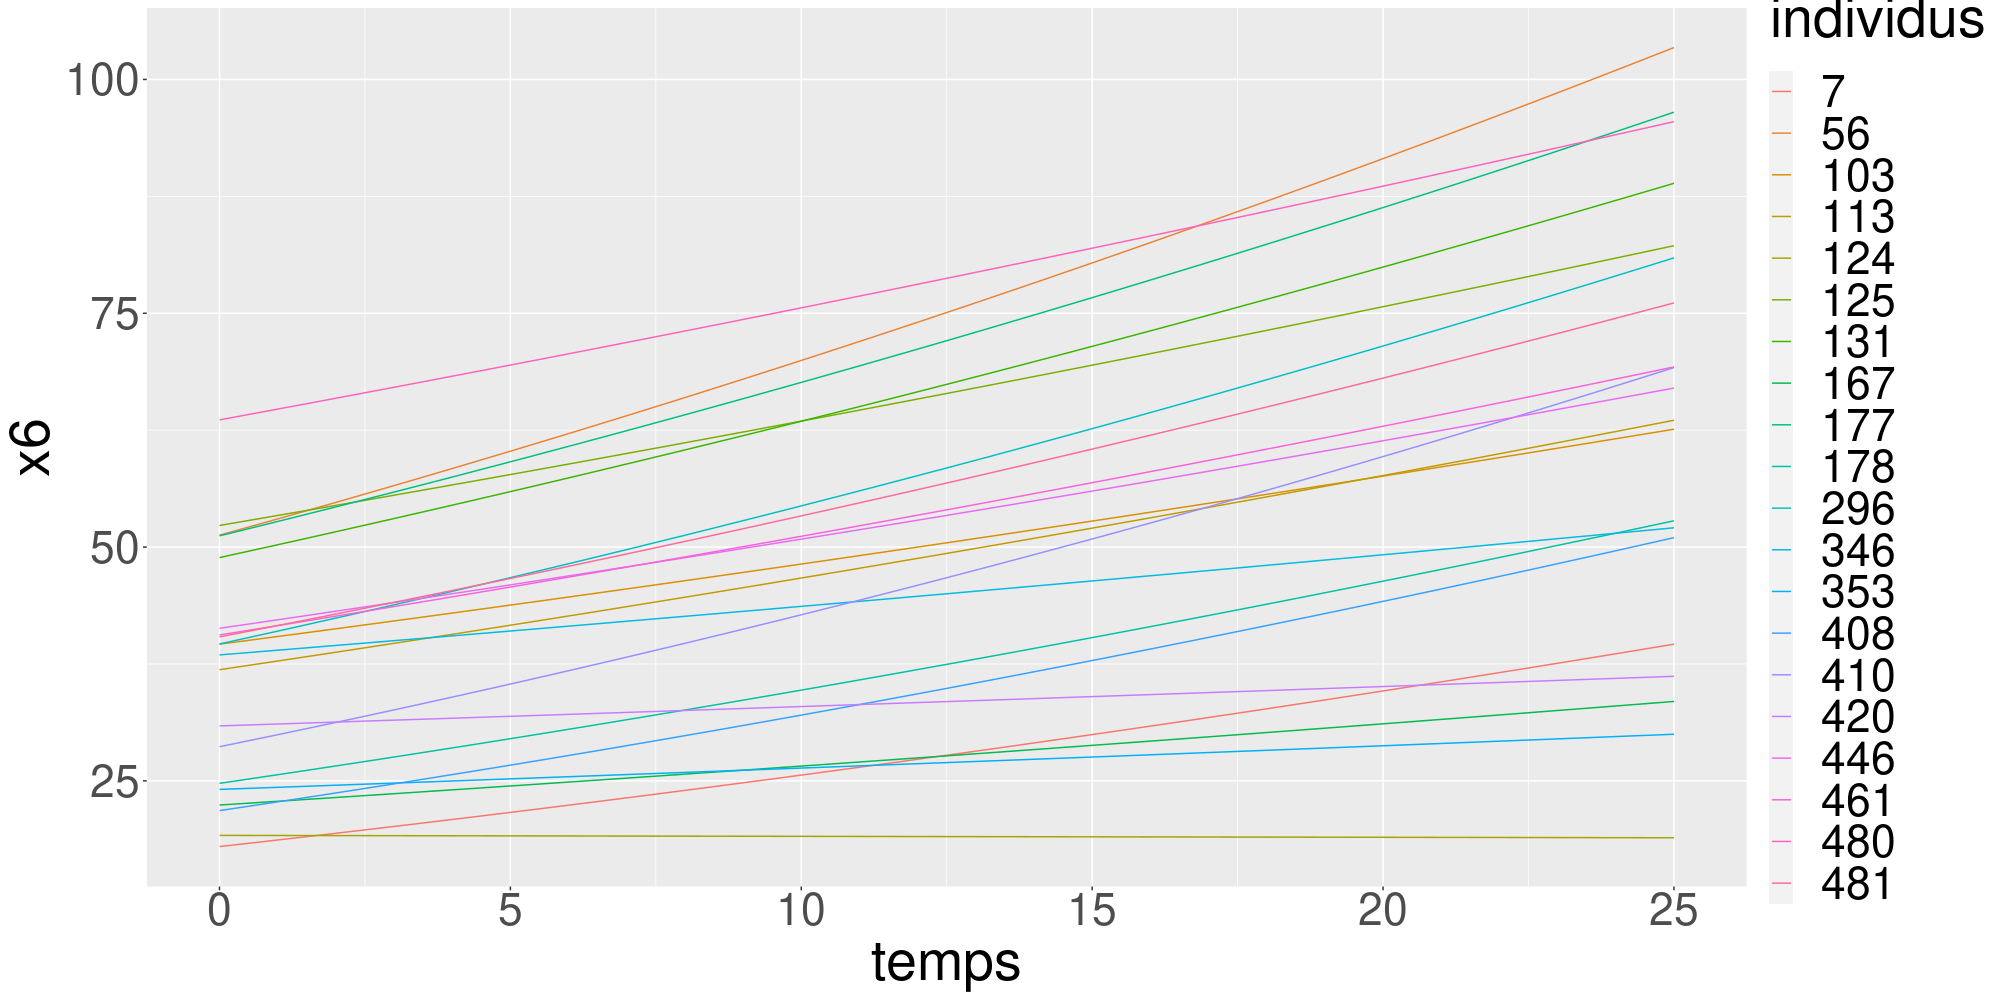

In [23]:
spagetthi('x6')

$X^*_{7,i}(t) = \frac{\alpha_{0,i}^7}{1+e^{-\alpha_{1,i}^7 t}}$

With:  

$\alpha_{0i}^k \sim \mathcal{N}(\mu_0^k , \sigma_0^k)$, $\mu_0^k \sim \mathcal{U}(-1, 1)$, $\sigma_0^k = 0.5$  
$\alpha_{1i}^k \sim \mathcal{N}(\mu_1^k , \sigma_1^k)$, $\mu_1^k \sim \mathcal{U}(-1, 1)$, $\sigma_1^{k \in \{1,2,4,7\}} = 0.5,~~\sigma_1^{3,6} = 0.1,~~\sigma_1^{k \in \{5\}} = 1$  